## Mills analysis

Analysis of the Mills et al. data

In [87]:
from pathlib import Path

import pickle
from functools import partial, reduce
import copy
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import cairosvg
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from mist.utils.plot_utils import *
from mist import utils
from tqdm import tqdm

from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import umap
import mpld3

set_style()

## Load data

In [88]:
input_folder = Path("../data/raw/mills/")
input_meta = input_folder / "cohort_meta"
input_cts_mzml = input_folder / "Mills_mzxml/gnps_fbn_export_quant.csv"

# Our results files
# Use HDMB + Orig
use_v1 = True
use_hmdb = True

# Use hmdb and results
#use_v1 = False
#use_hmdb = False

if use_v1:
    res_dir = Path("../data/raw/mills/model_predictions/")
else:
    res_dir = Path("../results/2023_05_10_prospective_reanalysis_forms/mills")

mills_embeds_files = res_dir / "embed_mills_0.p"

# Get smiles
inthmdb_smiles_out = res_dir / "inthmdb/smiles_outputs.tsv"
intpubchem_smiles_out = res_dir / "intpubchem/smiles_outputs.tsv"

save_dir = res_dir / "plots_redo_2023_05_10"
save_dir.mkdir(exist_ok=True)

In [89]:
def export_mol(mol, name, width=100, height=100):
    """Save substance structure as PDF"""
    # Render high resolution molecule
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height, )
    opts = drawer.drawOptions()        
    opts.bondLineWidth = 1
    drawer.DrawMolecule(mol, )
    drawer.FinishDrawing()
    cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=str(name))

## Extract cohort 2 meta data

In [90]:
cohort_2_meta = input_meta / "Combined_Metadata_Allomics_MP_V1.txt"
cohort_2_annots = input_meta / "Qemistree_IDs.txt"
cohort_2_cts = input_meta / "MB_Standardized_Table_Normalized_Final.txt"

In [91]:
cohort_2_meta_df = pd.read_csv(cohort_2_meta, sep="\t")

In [92]:
# Diagnoses --> Use this to subset to only UC or healthy patients
cohort_2_meta_df['Diagnosis'];

In [93]:
pt_to_act = {}
diag_to_file_2 = defaultdict(lambda : [])
name_to_diag = {}
for diag, name in cohort_2_meta_df[["Diagnosis", "Metabolomics_FileName"]].values:
    if "mzXML" in name:
        diag_to_file_2[diag].append(name)
    name_to_diag[name] = diag
len(diag_to_file_2['UC']), len(diag_to_file_2['Healthy_control'])
pt_to_act.update(dict(cohort_2_meta_df[['Metabolomics_FileName', 'Relative_Activity_Index']].values))

## Load in cts dfs

In [94]:
cohort_2_cts_df_authors = pd.read_csv(cohort_2_cts, sep="\t")
cohort_2_cts_df = pd.read_csv(input_cts_mzml, sep=",")

In [95]:
valid_keys = [i for i in cohort_2_cts_df.columns if "mzXML" in i or "row ID" in i]
valid_keys_remap = {i: i.split(" ")[0] for i in valid_keys}
valid_keys_remap['row ID'] = "#OTU ID"
cohort_2_cts_df = cohort_2_cts_df[valid_keys]
cohort_2_cts_df = cohort_2_cts_df.rename(axis=1, mapper=valid_keys_remap)

In [96]:
cohort_2_cts_df_temp = cohort_2_cts_df.set_index("#OTU ID")
sums = cohort_2_cts_df_temp.sum(axis=0)
sums = sums / 1000000.0
cohort_2_cts_df = cohort_2_cts_df_temp / sums
cohort_2_cts_df = cohort_2_cts_df.reset_index()


# Rename rows
cohort_2_cts_df["#OTU ID"] = [f"mills_{int(i)}" for i in cohort_2_cts_df["#OTU ID"].values]

In [97]:
# cohort 2 has 1,928 metabolites
cohort_2_cts_df.shape, cohort_2_cts_df_authors.shape 

((1990, 204), (1928, 188))

In [98]:
cohort_2_cts_df.keys(), cohort_2_cts_df.keys() ;

In [99]:
print("Finding missing keys")
disease_cts_in_df = []    
for j in cohort_2_cts_df.keys():
    if j == "#OTU ID": continue
    diag = name_to_diag.get(j)
    disease_cts_in_df.append(diag)    
    if diag not in ["UC", "CD", "Healthy_control", "IND"]:
        print(j, diag)

Finding missing keys
FIT010E3CAL_BD8_01_51898.mzXML None
FIT294E3CAL_GF4_01_52065.mzXML None
FIT278E3CAL_BA7_01_52102.mzXML None
FIT271E3CAL_BA9_01_52104.mzXML None
FIT273E3CAL_BB3_01_52111.mzXML None
FIT256E3CAL_BE2_01_52150.mzXML None
FIT276E3CAL_BE10_01_52159.mzXML None
FIT257E3CAL_BF9_01_52171.mzXML None


In [100]:
Counter(disease_cts_in_df)

Counter({'CD': 115, 'UC': 60, None: 8, 'IND': 1, 'Healthy_control': 19})

In [101]:
cohort_2_comp_ids = set(cohort_2_cts_df['#OTU ID'].values)

In [102]:
len(cohort_2_comp_ids)

1990

## Link annotations to count dfs
Get all compound entries from us and them!

In [103]:
# Map cohort to ids from their exported file
authors_cohort_2_annots_df = pd.read_csv(cohort_2_annots, sep="\t")
authors_cohort_2_id_to_smi = dict({k:v  for k,v in authors_cohort_2_annots_df[['rowid', "smiles"]].values 
                                   if v.lower() != "missing"})
their_forms = set([utils.form_from_smi(i) for i in authors_cohort_2_id_to_smi.values()])
print(f"Num they find: {len(authors_cohort_2_id_to_smi)}")

Num they find: 1126


Extract all identifications and compound clases from our predictions

In [104]:
all_pred_dfs = []
ikey_to_cls = {}
ikey_to_sup_cls = {}


# Get pubchem outputs
df = pd.read_csv(intpubchem_smiles_out, sep="\t")
df = df[df['rank'] == 0].reset_index()
inchikeys = utils.chunked_parallel(df['smi'].values, utils.inchikey_from_smiles);
df['inchikey'] = inchikeys
cls_file = pickle.load(open(intpubchem_smiles_out.parent / "chem_classes.p", "rb"))
ikey_to_cls.update(cls_file)
all_pred_dfs.append(df)

pred_df = pd.concat(all_pred_dfs)

# Get name_to_pred_cls_pubchem
name_to_pred_cls_pubchem = {i: ikey_to_cls[j] for i,j in pred_df[["name", "inchikey"]].values}
pred_cls_to_names_pubchem = defaultdict(lambda : [])
pred_supcls_to_names_pubchem = defaultdict(lambda : [])
for name, cls in name_to_pred_cls_pubchem.items():
    for sc in cls['class_results']: 
        pred_cls_to_names_pubchem[sc].append(name)
    for sc in cls['superclass_results']: 
        pred_supcls_to_names_pubchem[sc].append(name)

if use_hmdb:
    df = pd.read_csv(inthmdb_smiles_out, sep="\t")
    df = df[df['rank'] == 0].reset_index()
    inchikeys = utils.chunked_parallel(df['smi'].values, utils.inchikey_from_smiles);
    df['inchikey'] = inchikeys
    cls_file = pickle.load(open(inthmdb_smiles_out.parent / "chem_classes.p", "rb"))
    ikey_to_cls.update(cls_file)
    all_pred_dfs.append(df)
 
pred_df = pd.concat(all_pred_dfs)

name_to_pred_cls_hmdb = {i: ikey_to_cls[j] for i,j in pred_df[["name", "inchikey"]].values}
pred_cls_to_names_hmdb = defaultdict(lambda : [])
pred_supcls_to_names_hmdb = defaultdict(lambda : [])
for name, cls in name_to_pred_cls_hmdb.items():
    for sc in cls['class_results']: 
        pred_cls_to_names_hmdb[sc].append(name)
    for sc in cls['superclass_results']: 
        pred_supcls_to_names_hmdb[sc].append(name)



  0%|          | 0/100 [00:00<?, ?it/s]RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without neighbors
 38%|███▊      | 38/100 [00:00<00:00, 185.77it/s]RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without neighbors
 57%|█████▋    | 57/100 [00:00<00:00, 183.92it/s]RDKit WARNING: [18:08:08] WARNING: not removing hydrogen atom without neighbors
[18:08:08] WARNING: not removing hydrogen atom without nei

In [105]:
# Note a 50% discrepancy here; this could be improved.
forms = set(pd.unique(pred_df['form']))
len(forms.intersection(their_forms)), len(their_forms), len(forms)

(461, 892, 1239)

In [106]:
# Convert the id to smi
id_to_smi = dict(pred_df[['name', 'smi']].values)
id_to_ikey = dict(pred_df[['name', 'inchikey']].values)

print(f"Num we find: {len(id_to_smi)}")


Num we find: 1499


Find out how many superlcasses we find

In [107]:
num1 = len(set([j for i in pred_cls_to_names_hmdb.values() for j in i])), len(set([j for i in pred_supcls_to_names_hmdb.values() for j in i]))
num2 = len(set([j for i in pred_cls_to_names_pubchem.values() for j in i])), len(set([j for i in pred_supcls_to_names_pubchem.values() for j in i]))
num3 = len(pred_cls_to_names_pubchem['Dipeptides']), len(pred_supcls_to_names_pubchem['Small peptides'])
num4 = len(pred_cls_to_names_hmdb['Dipeptides']), len(pred_supcls_to_names_hmdb['Small peptides'])

print(f"Num total per cls / supclass for pubchem then hmdb: {num1}, {num2}")
print(f"Num dipeptides/small peptid ines pubchem then hmdb: {num3}, {num4}")

Num total per cls / supclass for pubchem then hmdb: (1039, 1096), (1003, 1073)
Num dipeptides/small peptid ines pubchem then hmdb: (137, 290), (137, 306)


## Dataframe construction

Building dataframes for metabolite counts for each cohort patient at the level of metabolite, class, and superclass (NPClassifier annotations)

In [108]:
melted_df_2 = cohort_2_cts_df.melt(id_vars='#OTU ID').rename({"variable": "sample", "value": "inten", "#OTU ID": "compound_id"}, axis=1)
melted_df_2

,compound_id,sample,inten
0,mills_1,FIT094E3CAL_BA4_01_51852.mzXML,620.256602
1,mills_2,FIT094E3CAL_BA4_01_51852.mzXML,723.825215
2,mills_3,FIT094E3CAL_BA4_01_51852.mzXML,1440.194880
3,mills_4,FIT094E3CAL_BA4_01_51852.mzXML,292.999412
4,mills_5,FIT094E3CAL_BA4_01_51852.mzXML,321.202203
...,...,...,...
403965,mills_1986,FIT239E3CAL_BF12_01_52174.mzXML,1386.714532
403966,mills_1987,FIT239E3CAL_BF12_01_52174.mzXML,396.644620
403967,mills_1988,FIT239E3CAL_BF12_01_52174.mzXML,531.087394
403968,mills_1989,FIT239E3CAL_BF12_01_52174.mzXML,0.000000


In [109]:
pt_to_act;
melted_df_2['diagnosis'] = [name_to_diag.get(i, "") for i in melted_df_2['sample']]
melted_df_2['activity'] = [pt_to_act.get(i, np.nan) for i in melted_df_2['sample']]
melted_df_2['activity'] = [float(i) 
                           if not isinstance(i, str) or i.lower() != "missing" 
                           else np.nan 
                           for i in melted_df_2['activity'].values]

In [110]:
# melted_df_2['smiles'] = [cohort_2_id_to_smi.get(i, "") for i in melted_df_2['compound_id']]
melted_df_2['smiles'] = [id_to_smi.get(i, "unknown") for i in melted_df_2["compound_id"]]
melted_df_2['inchikey'] = [id_to_ikey.get(i, "unknown") for i in melted_df_2["compound_id"]]

In [111]:
# Choosing by random choice
sclass_res = [name_to_pred_cls_hmdb.get(i, {}).get("superclass_results", []) for i in melted_df_2["compound_id"]]
sclass_res = [np.random.choice(i) if len(i) > 0 else "unknown" for i in sclass_res ]
melted_df_2['superclass_results'] = sclass_res 
class_res = [name_to_pred_cls_hmdb.get(i, {}).get("class_results", []) for i in melted_df_2["compound_id"]]
class_res = [np.random.choice(i) if len(i) > 0 else "unknown" for i in class_res ]
melted_df_2['class_results'] = class_res 

In [112]:
# We can make class df's and molecule df'
Counter([len(name_to_pred_cls_hmdb.get(i, {}).get("class_results", [])) for i in melted_df_2["compound_id"]])

Counter({0: 193053, 1: 192444, 2: 18067, 4: 203, 3: 203})

In [113]:
# Creating new df's specifically for superclass and class
# This is necessary because they are not unique
out_name_to_df = {"compound_id": melted_df_2}
melted_df_records = melted_df_2.to_dict(orient="records")
for k in ["superclass_results", "class_results"]:
    sclass_df = []
    for row in tqdm(melted_df_records): 
        comp_id = row['compound_id']
        all_sclasses = name_to_pred_cls_hmdb.get(comp_id, {}).get(k, [])
        if len(all_sclasses) == 0: all_sclasses = ["unknown"]
        for sclass in all_sclasses:
            row_temp = copy.deepcopy(row)
            row_temp[k] = sclass
            sclass_df.append(row_temp)
    out_name_to_df[k] = pd.DataFrame(sclass_df)

100%|██████████| 403970/403970 [00:03<00:00, 112115.72it/s]


In [114]:
len(pd.unique(melted_df_2['smiles'])), len(pd.unique(out_name_to_df['superclass_results']['smiles'])), len(pd.unique(out_name_to_df['class_results']['smiles']))

(1345, 1345, 1345)

## Generating plots

### Consider _all_ classes and their correlation with disease severity

In [115]:
def compute_int_from_r_n(r, n, alpha=0.05):
    alpha = alpha / 2 # Two-tail test
    z_critical = stats.norm.ppf(1 - alpha)
    z_prime = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3) # Sample standard error
    CI_lower = z_prime - z_critical * se
    CI_upper = z_prime + z_critical * se
    return CI_lower, CI_upper
    
    

In [116]:
## Explicitly look at per metabolite correlations
level = "class_results" 

# level = "compound_id"
all_correlation_list  = []
temp_df = out_name_to_df[level]
temp_melted_2 = temp_df[~pd.isna(temp_df['activity'])]
for cohort_name, cohort_df in [("cohort 2", temp_melted_2)]:
    for diagnosis, temp_df in cohort_df.groupby("diagnosis"):
        if diagnosis not in ["UC", "CD"] : continue
        reformatted_2 = temp_df.pivot_table(index=["sample", "activity", "diagnosis"], columns=[level], 
                                            values=["inten"], aggfunc="sum")
        for act_ind in reformatted_2.keys():
            reset_ind  = reformatted_2.reset_index()
            acts = reset_ind['activity']
            intens = reset_ind[act_ind]

            slope, intercept, r_value, p_value, std_err = stats.linregress(acts.values,intens.values)
            rho, rho_p = stats.pearsonr(acts.values, intens.values, )
            ci_lower, ci_upper = compute_int_from_r_n(rho, len(acts))
            new_entry = {"diagnosis": diagnosis, "index": act_ind[1], "R": r_value, "cohort": cohort_name,
                        "rho": rho, "rho_p": rho_p, "rho_ci_lower":ci_lower, "rho_ci_upper": ci_upper}
            all_correlation_list.append(new_entry)
correl_df = pd.DataFrame(all_correlation_list)
correl_df

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/samlg/.conda/envs/ms-gen/lib/pytho

,diagnosis,index,R,cohort,rho,rho_p,rho_ci_lower,rho_ci_upper
0,CD,3-acyl tetramic acids,0.100827,cohort 2,0.100827,0.313300,-0.095813,0.298154
1,CD,Abeolupane triterpenoids,-0.012098,cohort 2,-0.012098,0.903939,-0.209083,0.184885
2,CD,Abietane diterpenoids,-0.138791,cohort 2,-0.138791,0.164168,-0.336676,0.057291
3,CD,Acetogenins,0.120073,cohort 2,0.120073,0.229330,-0.076329,0.317639
4,CD,Acridone alkaloids,-0.181067,cohort 2,-0.181067,0.068571,-0.380070,0.013898
...,...,...,...,...,...,...,...,...
351,UC,Unsaturated fatty acids,-0.244128,cohort 2,-0.244128,0.060138,-0.508763,0.010444
352,UC,Wax monoesters,-0.119669,cohort 2,-0.119669,0.362438,-0.379848,0.139359
353,UC,Yohimbine-like alkaloids,-0.053422,cohort 2,-0.053422,0.685191,-0.313076,0.206131
354,UC,pteridine alkaloids,-0.012956,cohort 2,-0.012956,0.921732,-0.272561,0.246646


In [117]:
correct_method="fdr_bh"
isnan= np.isnan(correl_df['rho_p'].values)
_reject, pval_adjust, _alph1, alph2 = multipletests(correl_df['rho_p'].values[~isnan], alpha=0.05, method=correct_method)
pval_adjust_full = np.ones(len(correl_df))
pval_adjust_full[~isnan] = pval_adjust
correl_df['rho_p_adjust']= pval_adjust_full

In [118]:
correl_df[correl_df['index'] == "Dipeptides"]

,diagnosis,index,R,cohort,rho,rho_p,rho_ci_lower,rho_ci_upper,rho_p_adjust
53,CD,Dipeptides,0.103199,cohort 2,0.103199,0.301990,-0.093416,0.300552,0.586385
231,UC,Dipeptides,0.477647,cohort 2,0.477647,0.000114,0.260328,0.779535,0.010173


In [119]:
np.sum(~isnan), correl_df['rho_p'].values[~isnan].shape

(350, (350,))

In [120]:
pval_adjust.shape

(350,)

In [121]:
col_vals = ["R", "rho", "rho_p", "rho_ci_lower", "rho_ci_upper"]
correl_df_pivot = correl_df.pivot_table(values=col_vals, index="index", 
                                        columns="diagnosis").reset_index()
for col in col_vals:
    correl_df_pivot[(col, 'mean')] = (correl_df_pivot[(col, 'CD')] + correl_df_pivot[(col, 'UC')]) / 2

mean_sort = correl_df_pivot.sort_values(by=("rho", "mean"), ascending=False )
uc_sort = correl_df_pivot.sort_values(by=("rho", "UC"), ascending=False )
mean_sort[:10]

index         R                 rho  \
diagnosis                                           CD        UC        CD   
61                     Fatty acyl carnitines  0.374936  0.425829  0.374936   
43            Cinnamic acids and derivatives  0.350064  0.448660  0.350064   
153                  Simple indole alkaloids  0.289441  0.469510  0.289441   
16             Anthranillic acid derivatives  0.274470  0.436376  0.274470   
53                                Dipeptides  0.103199  0.477647  0.103199   
9                                 Aminoacids  0.351658  0.208767  0.351658   
74                     Glycerophosphoserines  0.198769  0.337934  0.198769   
152        Simple diketopiperazine alkaloids  0.155572  0.369370  0.155572   
72               Glycerophosphoethanolamines  0.165197  0.356271  0.165197   
106                            N-acyl amines  0.389705  0.092601  0.389705   

                    rho_ci_lower           rho_ci_upper               rho_p  \
diagnosis        UC           CD        UC           CD        UC        CD   
61         0.425829     0.197171  0.195188     0.591138  0.714395  0.000103   
43         0.448660     0.168533  0.223418     0.562501  0.742625  0.000310   
153        0.469510     0.100972  0.249838     0.494940  0.769046  0.003171   
16         0.436376     0.084708  0.208141     0.478676  0.727349  0.005244   
53         0.477647    -0.093416  0.260328     0.300552  0.779535  0.301990   
9          0.208767     0.170351 -0.047722     0.564318  0.471485  0.000290   
74         0.337934     0.004467  0.092155     0.398435  0.611362  0.045203   
152        0.369370    -0.040138  0.128089     0.353829  0.647296  0.118439   
72         0.356271    -0.030259  0.113004     0.363709  0.632211  0.097062   
106        0.092601     0.214469 -0.166737     0.608436  0.352470  0.000052   

                            R       rho     rho_p rho_ci_lower rho_ci_upper  
diagnosis        UC      mean      mean      mean         mean         mean  
61         0.000694  0.400383  0.400383  0.000398     0.196179     0.652767  
43         0.000324  0.399362  0.399362  0.000317     0.195976     0.652563  
153        0.000154  0.379476  0.379476  0.001663     0.175405     0.631993  
16         0.000491  0.355423  0.355423  0.002867     0.146425     0.603012  
53         0.000114  0.290423  0.290423  0.151052     0.083456     0.540044  
9          0.109426  0.280212  0.280212  0.054858     0.061314     0.517902  
74         0.008272  0.268352  0.268352  0.026738     0.048311     0.504899  
152        0.003679  0.262471  0.262471  0.061059     0.043975     0.500563  
72         0.005207  0.260734  0.260734  0.051135     0.041373     0.497960  
106        0.481615  0.241153  0.241153  0.240833     0.023866     0.480453

In [122]:
# Plot the correlations as a barplot--> sort by sum

In [123]:
uc_color = "#EDB05B"
cd_color = "#98BFC4"
healthy_color = "#EECCBE"

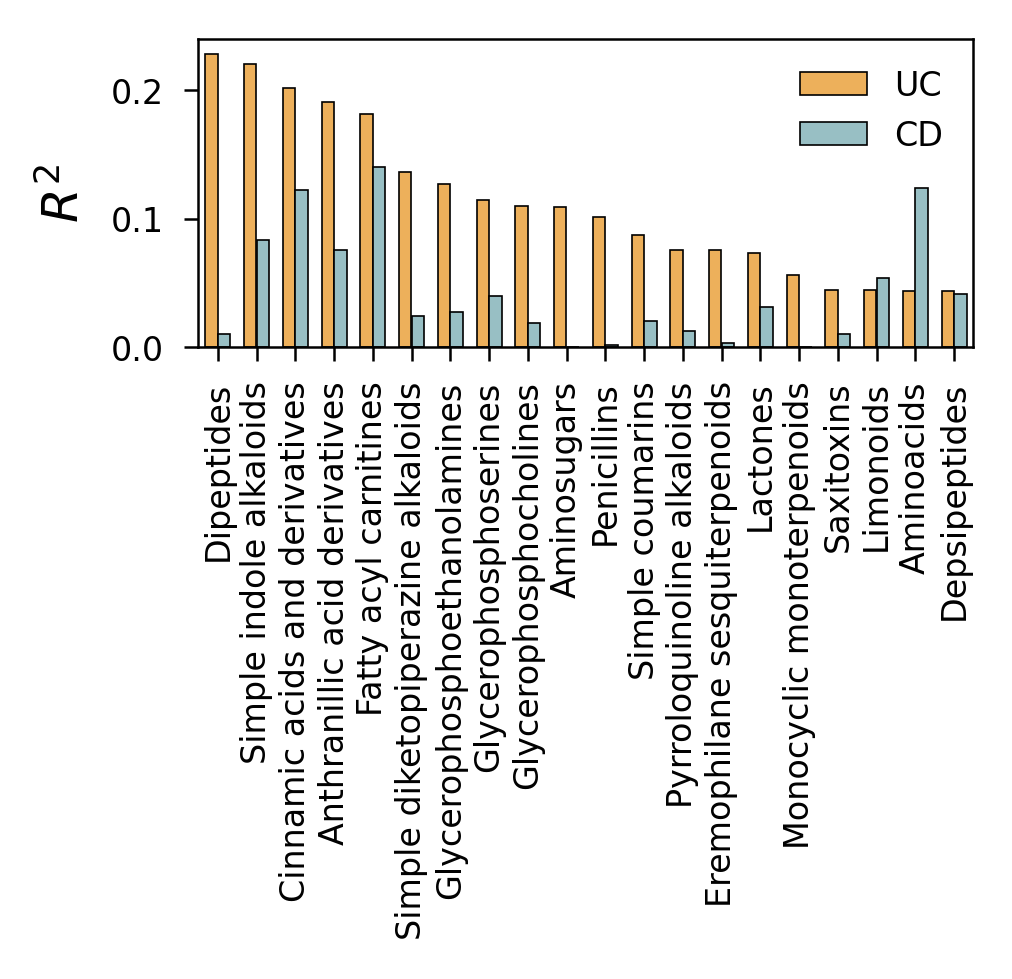

In [124]:
top_k = 20
inds = uc_sort['index'].values[:top_k]
uc_cd_vals = uc_sort[[('rho', 'UC'), ('rho', 'CD')]].values[:top_k]


figsize=(2.5,1.0)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.gca()

space_factor = 2.5
color=uc_color
out = ax.bar(space_factor*np.arange(len(inds))-0.41, uc_cd_vals[:,0]**2, width=0.8,
             color = color, edgecolor="black", linewidth=0.3, label="UC")
color=cd_color
out = ax.bar(space_factor*np.arange(len(inds))+0.41, uc_cd_vals[:,1]**2, width=0.8,
             color = color, edgecolor="black", linewidth=0.3, label="CD")

ax.set_xticks(space_factor*np.arange(len(inds)))
ax.set_xticklabels(inds, rotation=90);
ax.set_ylabel("$R^2$")
legend = ax.legend(loc='upper right', frameon=False, facecolor="none", 
                   fancybox=False)
ax.set_xlim([-1.3, space_factor * len(inds) - 1.3])
legend.get_frame().set_facecolor('none')


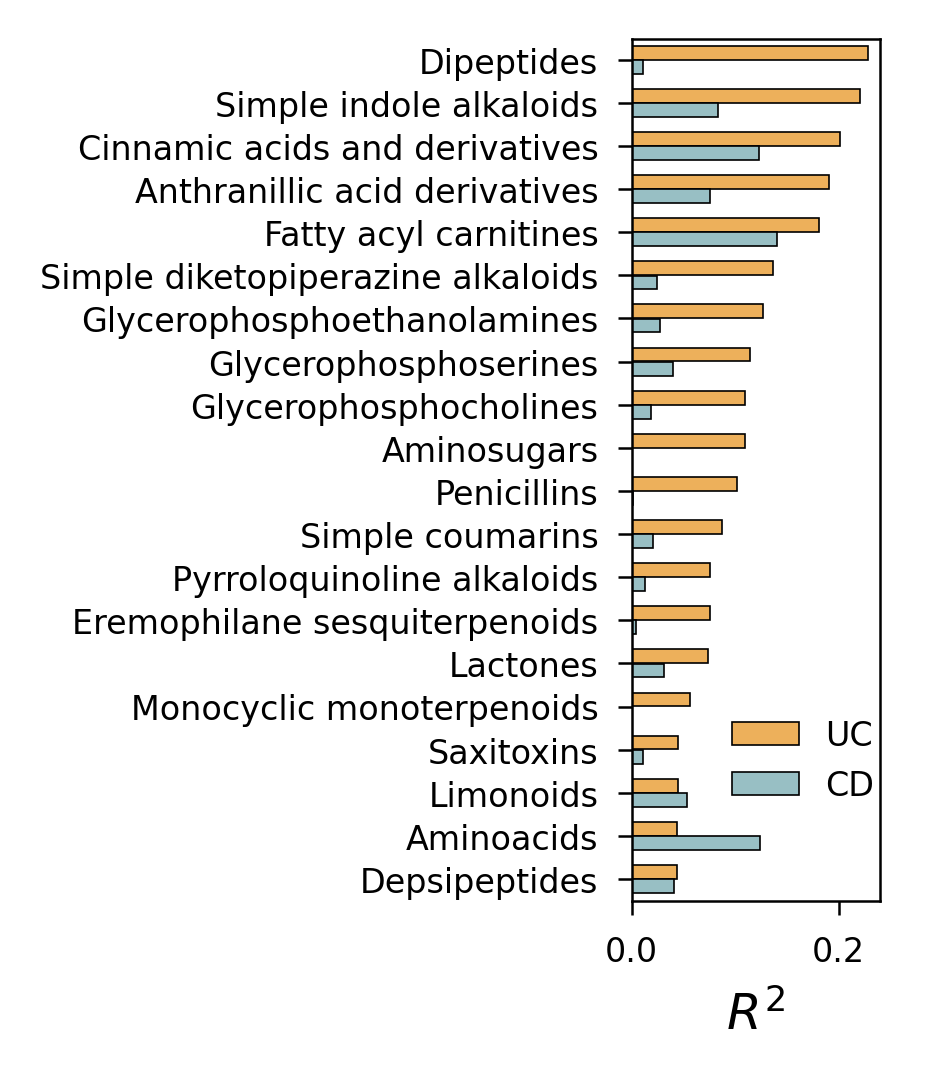

In [125]:
top_k = 20
inds = uc_sort['index'].values[:top_k][::-1]

uc_cd_vals = uc_sort[[('rho', 'UC'), ('rho', 'CD')]].values[:top_k][::-1]
uc_cd_lower = uc_sort[[('rho_ci_lower', 'UC'), ('rho_ci_lower', 'CD')]].values[:top_k][::-1]
uc_cd_upper = uc_sort[[('rho_ci_upper', 'UC'), ('rho_ci_upper', 'CD')]].values[:top_k][::-1]
diff_lower = uc_cd_vals - uc_cd_lower
diff_upper = uc_cd_upper - uc_cd_vals 



figsize=(0.8, 2.8)#(2.5,1.0)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.gca()

space_factor = 2.5
color=uc_color
out = ax.barh(space_factor*np.arange(len(inds))+0.41, uc_cd_vals[:,0]**2,#width=0.8,
             color = color, edgecolor="black", linewidth=0.3, label="UC")
color=cd_color
out = ax.barh(space_factor*np.arange(len(inds))-0.41, uc_cd_vals[:,1]**2, #width=0.8,
             color = color, edgecolor="black", linewidth=0.3, label="CD")
# color=uc_color
# out = ax.scatter(y=space_factor*np.arange(len(inds))+0.41, x=uc_cd_vals[:,0],#width=0.8,
#                  color = color, s=2, linewidth=0.3, label="UC",)

# out = ax.errorbar(y=space_factor*np.arange(len(inds))+0.41, x=uc_cd_vals[:,0],
#                   color = color, linewidth=0.3, xerr=(diff_lower[:, 0], diff_upper[:, 0]), ls="none")
# color=cd_color
# out = ax.scatter(y=space_factor*np.arange(len(inds))-0.41, x=uc_cd_vals[:,1],#width=0.8,
#                  color = color, s=2, linewidth=0.3, label="CD",)
# out = ax.errorbar(y=space_factor*np.arange(len(inds))-0.41, x=uc_cd_vals[:,1],
#                   color = color, linewidth=0.3, xerr=(diff_lower[:, 1], diff_upper[:, 1]), ls="none")



ax.set_yticks(space_factor*np.arange(len(inds)))
ax.set_yticklabels(inds);
ax.set_xlabel("$R^2$")
# ax.set_xlabel("$R$")
legend = ax.legend(loc=(0.35, 0.1), frameon=False, facecolor="none", 
                   fancybox=False)
# legend = ax.legend(loc=(-0.1, 0.0), frameon=False, facecolor="none", 
#                    fancybox=False, columnspacing=0.1, handletextpad=-0.3,
#                    markerscale=2, labelspacing=0.07
#                   )
ax.set_ylim([-1.3, space_factor * len(inds) - 1.3])

legend.get_frame().set_facecolor('none')
fig.savefig(save_dir / "cls_correl.pdf", bbox_inches="tight", transparent=True)

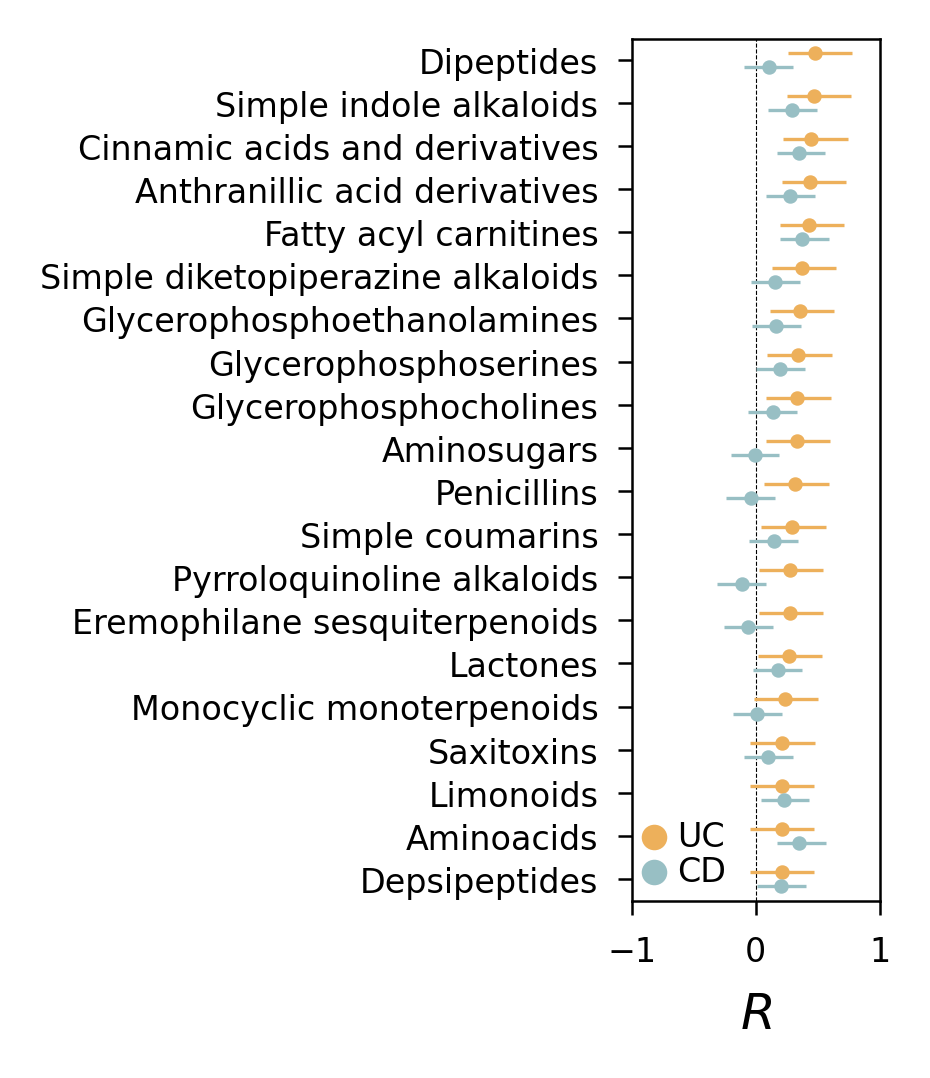

In [126]:
top_k = 20
inds = uc_sort['index'].values[:top_k][::-1]

uc_cd_vals = uc_sort[[('rho', 'UC'), ('rho', 'CD')]].values[:top_k][::-1]
uc_cd_lower = uc_sort[[('rho_ci_lower', 'UC'), ('rho_ci_lower', 'CD')]].values[:top_k][::-1]
uc_cd_upper = uc_sort[[('rho_ci_upper', 'UC'), ('rho_ci_upper', 'CD')]].values[:top_k][::-1]
diff_lower = uc_cd_vals - uc_cd_lower
diff_upper = uc_cd_upper - uc_cd_vals 



figsize=(0.8, 2.8)#(2.5,1.0)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.gca()

space_factor = 2.5
# color=uc_color
# out = ax.barh(space_factor*np.arange(len(inds))+0.41, uc_cd_vals[:,0]**2,#width=0.8,
#              color = color, edgecolor="black", linewidth=0.3, label="UC")
# color=cd_color
# out = ax.barh(space_factor*np.arange(len(inds))-0.41, uc_cd_vals[:,1]**2, #width=0.8,
#              color = color, edgecolor="black", linewidth=0.3, label="CD")
color=uc_color
out = ax.scatter(y=space_factor*np.arange(len(inds))+0.41, x=uc_cd_vals[:,0],#width=0.8,
                 color = color, s=4, linewidth=0.6, label="UC",)

out = ax.errorbar(y=space_factor*np.arange(len(inds))+0.41, x=uc_cd_vals[:,0],
                  color = color, linewidth=0.6, xerr=(diff_lower[:, 0], diff_upper[:, 0]), ls="none")
color=cd_color
out = ax.scatter(y=space_factor*np.arange(len(inds))-0.41, x=uc_cd_vals[:,1],#width=0.8,
                 color = color, s=4, linewidth=0.6, label="CD",)
out = ax.errorbar(y=space_factor*np.arange(len(inds))-0.41, x=uc_cd_vals[:,1],
                  color = color, linewidth=0.6, xerr=(diff_lower[:, 1], diff_upper[:, 1]), ls="none")



ax.set_yticks(space_factor*np.arange(len(inds)))
ax.set_yticklabels(inds);
# ax.set_xlabel("$R^2$")
ax.set_xlabel("$R$")
legend = ax.legend(loc=(0.35, 0.1), frameon=False, facecolor="none", 
                   fancybox=False)
legend = ax.legend(loc=(-0.1, 0.0), frameon=False, facecolor="none", 
                   fancybox=False, columnspacing=0.1, handletextpad=-0.3,
                   markerscale=2, labelspacing=0.07
                  )
ax.set_ylim([-1.3, space_factor * len(inds) - 1.3])
ax.set_xlim([-1, 1])
ax.axvline(x=0, color="black", linestyle="--", linewidth=0.2, zorder=-1)
legend.get_frame().set_facecolor('none')
fig.savefig(save_dir / "cls_correl.pdf", bbox_inches="tight", transparent=True)

### Correlations with disease severity and boxplot of health vs. disease

UC R, R^2, p value: 0.4776472059479495, 0.23, 0.00011374761801989665
CD R, R^2, p value: 0.10319937175476371, 0.01, 0.3019896341761623


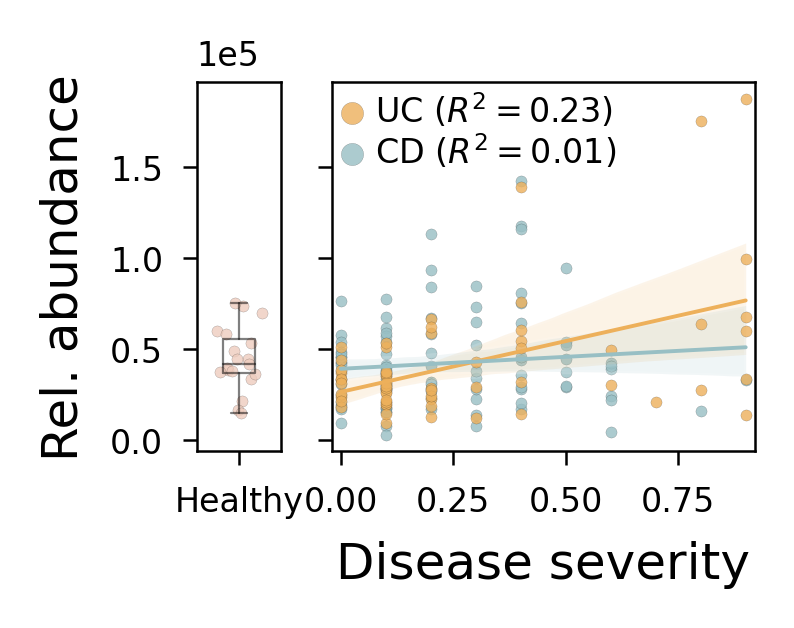

In [127]:
# key = "superclass_results"
# val = "Small peptides"

# key = "superclass_results"
# val = "Phenylpropanoids (C6-C3)"
key = "class_results"
val = "Dipeptides"
test_df = out_name_to_df[key]

boxprops = {"color":"black", "alpha":0.5, "linewidth":0.4}
figsize=(1.8, 1.2)



temp_melted_2 = test_df[~pd.isna(test_df['activity'])]
uc_df = temp_melted_2[temp_melted_2['diagnosis'] == "UC"]
uc_pivot = uc_df.pivot_table(index=["sample", "activity", "diagnosis"], columns=[key], 
                             values=["inten"], aggfunc="sum").reset_index()
uc_acts = uc_pivot['activity'].values
uc_dipeps = uc_pivot[("inten", val)].values 
                              
cd_df = temp_melted_2[temp_melted_2['diagnosis'] == "CD"]
cd_pivot = cd_df.pivot_table(index=["sample", "activity", "diagnosis"], columns=[key], 
                             values=["inten"], aggfunc="sum").reset_index()
cd_acts = cd_pivot['activity'].values
cd_dipeps  = cd_pivot[("inten", val)].values


healthy_df = temp_melted_2[temp_melted_2['diagnosis'] == "Healthy_control"]
healthy_pivot = healthy_df.pivot_table(index=["sample", "activity", "diagnosis"], columns=[key], 
                                       values=["inten"], aggfunc="sum").reset_index()
healthy_acts = healthy_pivot['activity'].values
healthy_dipeps  = healthy_pivot[("inten", val)].values

_, _, uc_r_val, uc_p_val, _ = stats.linregress(uc_acts, uc_dipeps)
_, _, cd_r_val, cd_p_val, _ = stats.linregress(cd_acts, cd_dipeps)
print(f"UC R, R^2, p value: {uc_r_val}, {uc_r_val**2:.2f}, {uc_p_val}")
print(f"CD R, R^2, p value: {cd_r_val}, {cd_r_val**2:.2f}, {cd_p_val}")

f, (ax1, ax2) = plt.subplots(figsize=figsize, nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 5]},
                             dpi=400, sharey=True)

x_jitter = np.random.normal(size=len(healthy_dipeps), scale=0.05)
ax1.boxplot(positions=[0], x=healthy_dipeps, showfliers=False, 
            medianprops=boxprops,
            boxprops=boxprops,
            capprops=boxprops,
            whiskerprops=boxprops
          )
ax1.scatter(x=healthy_acts + x_jitter, y=healthy_dipeps, s = 4, alpha=0.8, 
            color=healthy_color, edgecolor="black", linewidth=0.03,)
ax1.set_xticklabels(["Healthy"])
ax1.set_ylabel("Rel. abundance")
ax1.set_xlim([-0.2,0.2])
sns.regplot(x=uc_acts, y=uc_dipeps, fit_reg=True, scatter=False, color=uc_color, ax= ax2, line_kws=dict(linewidth=0.7));
sns.regplot(x=cd_acts, y=cd_dipeps, fit_reg=True, scatter=False, color=cd_color, ax= ax2, line_kws=dict(linewidth=0.7));
ax2.scatter(x=uc_acts, y=uc_dipeps, color=uc_color, edgecolor="black", linewidth=0.03, s=4, alpha=0.8,
            label=fr"UC $(R^2={uc_r_val**2:0.2f}$)",zorder=1)
ax2.scatter(x=cd_acts, y=cd_dipeps, color=cd_color, edgecolor="black", linewidth=0.03, s=4, alpha=0.8, 
           label=fr"CD $(R^2={cd_r_val**2:0.2f}$)", zorder=0)
ax2.set_xlim([-0.02, 0.92])
ax2.set_xlabel("Disease severity")
# legend = ax2.legend(loc="center", frameon=False, facecolor="none", bbox_to_anchor=(0.5, 1.1),
#                    fancybox=False, ncol=2, columnspacing=0.1, handletextpad=-0.3, markerscale=2)
legend = ax2.legend(loc="center", frameon=False, facecolor="none", bbox_to_anchor=(0.32, 0.87),
                   fancybox=False, ncol=1, columnspacing=0.1, handletextpad=-0.3, markerscale=2, labelspacing=0.07)

ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

legend.get_frame().set_facecolor('none')
f.subplots_adjust(wspace=0.2)
f.savefig(save_dir/"correl_scatter.pdf", bbox_inches="tight", transparent=True)

### Make correlation plots at the level of metabolites for only dipeptide molecules

In [128]:
key = "Dipeptides"
valid_compounds = set(pred_cls_to_names_hmdb[key])

In [129]:
## Explicitly look at per metabolite correlations
level = "compound_id" 
all_correlation_list  = []
temp_df = out_name_to_df[level]
temp_melted_2 = temp_df[~pd.isna(temp_df['activity'])]
temp_melted_2 = temp_melted_2[[i in valid_compounds for i in temp_melted_2[level].values]]
for cohort_name, cohort_df in [("cohort 2", temp_melted_2)]:
    for diagnosis, temp_df in cohort_df.groupby("diagnosis"):
        if diagnosis not in ["UC", "CD"] : continue
        reformatted_2 = temp_df.pivot_table(index=["sample", "activity", "diagnosis"], columns=[level], 
                                            values=["inten"], aggfunc="sum")
        for act_ind in reformatted_2.keys():
            reset_ind  = reformatted_2.reset_index()
            acts = reset_ind['activity']
            intens = reset_ind[act_ind]

            slope, intercept, r_value, p_value, std_err = stats.linregress(acts.values,intens.values)
            new_entry = {"diagnosis": diagnosis, "index": act_ind[1], "R": r_value, "cohort": cohort_name}
            all_correlation_list.append(new_entry)
correl_df = pd.DataFrame(all_correlation_list)

In [130]:
correl_df_pivot = correl_df.pivot_table(values="R", index="index", columns="diagnosis").reset_index()
correl_df_pivot['mean'] = (correl_df_pivot['CD'] + correl_df_pivot['UC']) / 2
mean_sort = correl_df_pivot.sort_values(by="mean", ascending=False )
uc_sort = correl_df_pivot.sort_values(by="UC", ascending=False )
mean_sort[:10]

diagnosis,index,CD,UC,mean
25,mills_183,0.197961,0.446722,0.322341
119,mills_744,0.229762,0.406292,0.318027
105,mills_617,0.175434,0.440962,0.308198
100,mills_57,0.214517,0.382090,0.298303
28,mills_195,0.156749,0.425215,0.290982
84,mills_495,0.208505,0.357884,0.283194
36,mills_235,0.151462,0.414335,0.282898
33,mills_213,0.155732,0.396601,0.276167
66,mills_435,0.158383,0.389685,0.274034
74,mills_460,0.159710,0.379914,0.269812


In [131]:
mills_name_to_uc_corel = dict(uc_sort[["index", "UC"]].values)

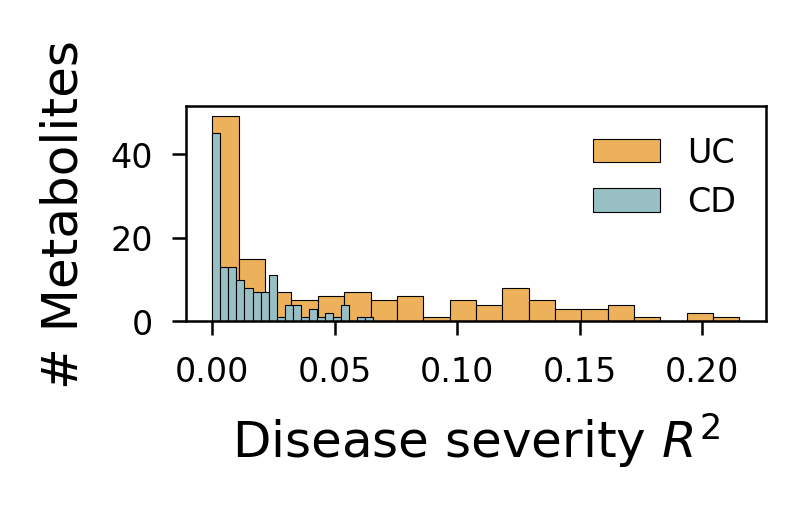

In [132]:
figsize=(1.87,0.7)
fig = plt.figure(figsize=figsize, dpi=400)
ax = fig.gca()

ax.hist(uc_sort["UC"].values**2, label="UC", bins=20, color=uc_color, edgecolor="black", linewidth=0.2)
ax.hist(uc_sort["CD"].values**2, label="CD", bins=20, color=cd_color, edgecolor="black", linewidth=0.2)
legend = ax.legend(loc='upper right', frameon=False, facecolor="none", 
                   fancybox=False)
ax.set_ylabel("# Metabolites")
# ax.set_title("Dipeptide metabolites")
ax.set_xlabel(r"Disease severity $R^2$")
legend.get_frame().set_facecolor('none')
fig.savefig(save_dir / "metab_dist.pdf", bbox_inches="tight", transparent=True)

### Load in CSI Data

In [133]:
# Our results files embedding nist2022 (csi2022 dataset)
csi_res_dir = Path("../results/2022_12_01_prospective_analysis/")
csi_embeds_files = csi_res_dir / "csi2022/embed_csi2022_0.p"
smi_to_cls_f = "../data/unpaired_mols/bio_mols/new_smi_to_classes.p"
csi_labels = f"../data/paired_spectra/csi2022/labels.tsv"

smi_to_cls = pickle.load(open(smi_to_cls_f, "rb"))
csi_cls_to_names = defaultdict(lambda : []);
csi_label_df = pd.read_csv(csi_labels, sep="\t")
csi_spec_to_smiles = dict(csi_label_df[["spec", "smiles"]].values)
csi_spec_to_smiles.update(id_to_smi)
csi_formulae = set(pd.unique(csi_label_df['formula']))
csi_ikeys = set(pd.unique(csi_label_df['inchikey']))

### Check where CSI and mist overlap

In [134]:
key = "Dipeptides"
valid_compounds = set(pred_cls_to_names_hmdb[key])

In [135]:
len(valid_compounds)

# 137 compounds called by our model
csi_dir = "../results/2023_05_08_sirius_check/sirius5s_out_summary/compound_identifications.tsv"
csi_res_df = pd.read_csv(csi_dir, sep="\t")
csi_res_to_smi = dict(csi_res_df[["id", "smiles"]].values)
csi_res_to_ikey = {f"mills_{k.rsplit('_', 1)[-1]}": utils.inchikey_from_smiles(v) for k, v in csi_res_to_smi.items()}
csi_res_to_ikey;

id_to_ikey = {k: utils.inchikey_from_smiles(v) for k, v in id_to_smi.items()}

# Find all keys where id_to_ikey and csi_res_to_ikey are the same and store as a list
equiv_ikeys = {k for k in id_to_ikey.keys() if csi_res_to_ikey.get(k) == id_to_ikey.get(k)}
len(equiv_ikeys)

RDKit WARNING: [18:09:01] WARNING: not removing hydrogen atom without neighbors
[18:09:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:09:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:09:01] WARNING: not removing hydrogen atom without neighbors
[18:09:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:09:01] WARNING: not removing hydrogen atom without neighbors
[18:09:01] WARNING: not removing hydrogen atom without neighbors
[18:09:01] WARNING: not removing hydrogen atom without neighbors


183

In [136]:
# Find all keys where id_to_ikey and csi_res_to_ikey are the same and store as a list
equiv_ikeys = {k for k in id_to_ikey.keys() if csi_res_to_ikey.get(k) == id_to_ikey.get(k)}
diff_ikeys  = {k for k in id_to_ikey.keys() if csi_res_to_ikey.get(k) != id_to_ikey.get(k)}
len(equiv_ikeys), len(diff_ikeys)

(183, 1316)

In [137]:
# Find all keys where id_to_ikey is _not_ in csi_ikeys
not_in_train = {k for k in id_to_ikey.keys() if id_to_ikey.get(k) not in csi_ikeys}

# All annotations not in training _and_ equiv between csi and mist
same_not_in_train = [i for i in not_in_train if i in equiv_ikeys]

In [138]:
[i for i in same_not_in_train if i in valid_compounds]

['mills_111', 'mills_247', 'mills_123', 'mills_119', 'mills_89']

In [139]:
id_to_smi['mills_89'], id_to_smi['mills_119'], id_to_smi['mills_111'], id_to_smi['mills_247'], id_to_smi['mills_123']

('[H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O',
 'CS(=O)CCC(NC(=O)CCC(N)C(=O)O)C(=O)O',
 'NC(CCCCNC1OC(CO)C(O)C(O)C1=O)C(=O)O',
 'NCC(=O)N1CCCC1C(=O)N1CC(O)CC1C(=O)O',
 'CC(C)C(NCC1(O)OC(CO)C(O)C1O)C(=O)O')

### Umap of dipeptide molecules colored by correlation!

Please note this next section is not repeatable, as it requires the presence of embedded NIST2020 standards, which we are not able to distribute due to its commercial nature

In [140]:
mills_embeds = pickle.load(open(mills_embeds_files, "rb"))
csi_embeds = pickle.load(open(csi_embeds_files, "rb"))

In [141]:
mills_embeds['embeds'].shape, mills_embeds['names']

((1787, 256),
 array(['mills_778', 'mills_1660', 'mills_1456', ..., 'mills_1658',
        'mills_370', 'mills_791'], dtype='<U10'))

In [142]:
embed_stacked = np.vstack([csi_embeds['embeds'], mills_embeds['embeds']])
names_stacked = np.concatenate([csi_embeds['names'], mills_embeds['names']])


In [143]:
## Step 1 is to embed both jointly
reducer = umap.UMAP(metric="cosine", min_dist=0.1, n_neighbors=15, spread=1., random_state=1)
umap_embeds = reducer.fit_transform(embed_stacked)

In [144]:
csi_len, mills_len = len(csi_embeds['names']), len(mills_embeds['names'])

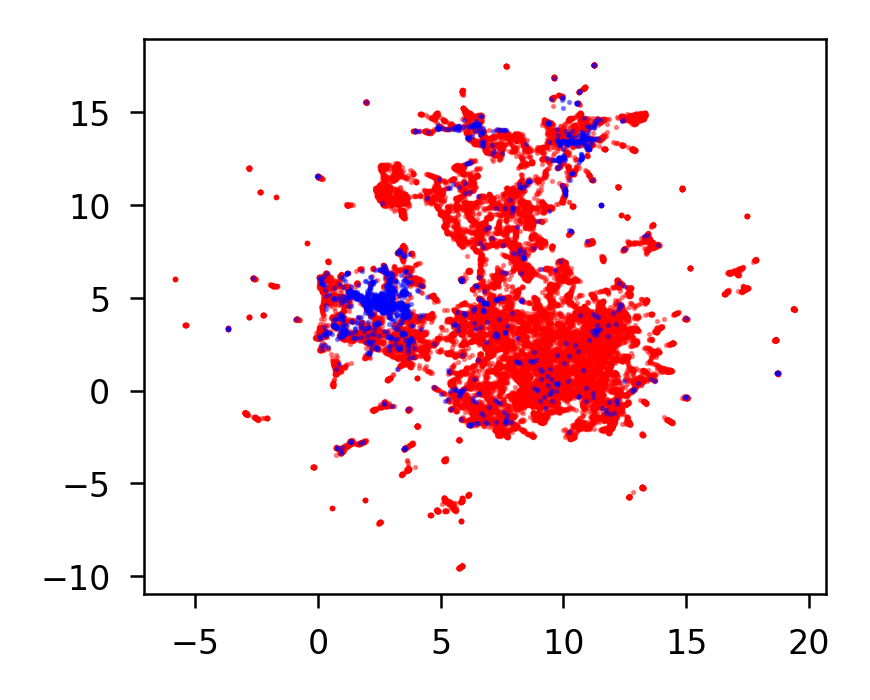

In [145]:
ax_sizes = (2.2, 1.8)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()

mills_embeds_mask = np.zeros(len(umap_embeds)).astype(bool)
mills_embeds_mask[csi_len:] = True
csi_embeds_mask = np.zeros(len(umap_embeds)).astype(bool)
csi_embeds_mask[:csi_len] = True
out = ax.scatter(umap_embeds[csi_embeds_mask, 0], 
                 umap_embeds[csi_embeds_mask, 1], 
                 label="csi",
                 color="red",
                 s=0.4,
                 linewidth=0.35,
                 alpha=0.4,
                )
out = ax.scatter(umap_embeds[mills_embeds_mask, 0], 
                 umap_embeds[mills_embeds_mask, 1], 
                 label="mills",
                 color="blue",
                 s=0.4,
                 linewidth=0.35,
                 alpha=0.4,
                )

Looking only at dipeptides in relation to _known_ dipeptides

In [146]:
csi_dipeps = []
for k,v in smi_to_cls.items():
    for cls in v['class_results']:
        if cls == "Dipeptides":
            csi_dipeps.append(k)

In [147]:
len(csi_dipeps)

960

In [148]:
mills_dipeps = pred_cls_to_names_hmdb["Dipeptides"]
mills_names_vec, mills_embeds_vec =  mills_embeds['names'], mills_embeds['embeds']
dipep_mask = [j in mills_dipeps for j in mills_names_vec]
mills_names_vec, mills_embeds_vec = mills_names_vec[dipep_mask], mills_embeds_vec[dipep_mask]
mills_r2_vec = np.array([mills_name_to_uc_corel[i] **2 for i in mills_names_vec])

In [149]:
csi_names_vec, csi_embeds_vec =  csi_embeds['names'], csi_embeds['embeds']
csi_dipep_mask = [j in csi_dipeps for j in csi_names_vec]
csi_names_vec, csi_embeds_vec = csi_names_vec[csi_dipep_mask], csi_embeds_vec[csi_dipep_mask]

In [150]:
concat_embed_vec = np.vstack([csi_embeds_vec, mills_embeds_vec])
concat_name_vec = np.concatenate([csi_names_vec, mills_names_vec])
is_mills = np.array(["mills_" in i for i in concat_name_vec])
not_mills = ~is_mills

In [70]:
concat_smiles = np.array([csi_spec_to_smiles.get(i) for i in concat_name_vec])
concat_form = [utils.form_from_smi(i) if i else "" for i in concat_smiles]
concat_ikey = [utils.inchikey_from_smiles(i) if i else "" for i in concat_smiles]
novel_form = [i not in csi_formulae for i in concat_form]
novel_ikey = [i not in csi_ikeys for i in concat_ikey]
novel_form_mills = [i not in csi_formulae for i in np.array(concat_form)[is_mills]]
novel_ikey_mills = [i not in csi_ikeys for i in np.array(concat_ikey)[is_mills]]

In [71]:
np.sum(novel_ikey_mills), np.sum(novel_ikey), np.sum(novel_form)

(56, 56, 45)

In [72]:
# Step 1 is to embed both jointly
reducer = umap.UMAP(metric="cosine", min_dist=0.1, n_neighbors=10, spread=0.6, random_state=4)
umap_embeds = reducer.fit_transform(concat_embed_vec)



In [86]:
umap_save = save_dir / "umap_embeds.p"
# Save coords
pickle.dump({"embeds": umap_embeds, "names": concat_name_vec}, open(umap_save, "wb"))

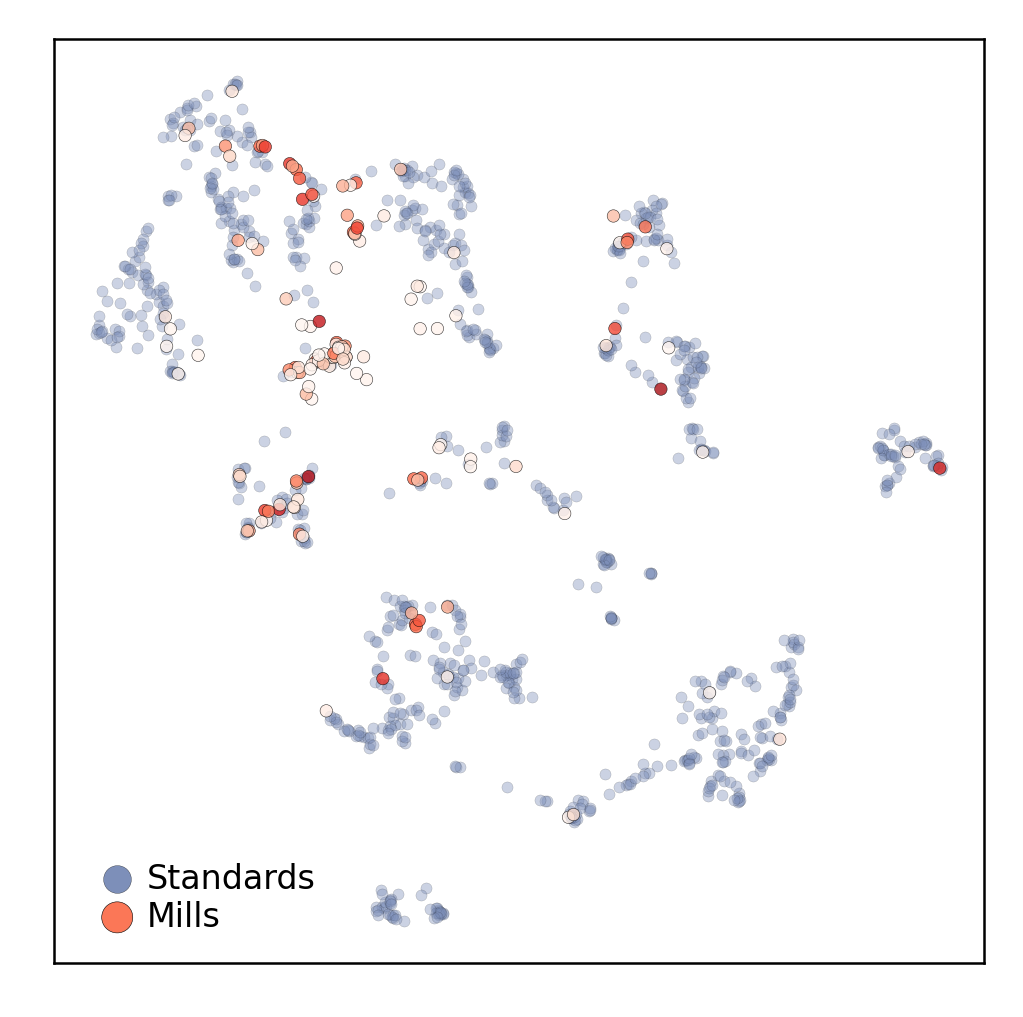

In [73]:
ax_sizes = (3, 3)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25

out = ax.scatter(umap_embeds[not_mills, 0], 
                 umap_embeds[not_mills, 1], 
                 label="Standards",
                 color="#7D8FB9",
                 edgecolors='black',
                 s=4,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.4,
                )

out = ax.scatter(umap_embeds[is_mills, 0], 
                 umap_embeds[is_mills, 1], 
                 c=mills_r2_vec,
                  cmap="Reds",
                 vmin=vmin,
                 vmax=vmax,
                 edgecolors='black',
                 s=5,
                 linewidth=0.1,
                 label="Mills",
                 alpha=0.8,
                 zorder=1

                )

ax.set_xticks([])
ax.set_yticks([])

legend = ax.legend(loc="lower left",
                   frameon=False, facecolor="white", fancybox=False, framealpha=1.0,
                   markerscale=2.5,
                   ncol=1,labelspacing=0.15, handletextpad=-0.1)
frame = legend.get_frame()
frame.set_linewidth(0.)
for lh in legend.legendHandles:
    lh.set_alpha(1)
fig.savefig(save_dir / "umap_dist.png", bbox_inches="tight", transparent=True, dpi=400)

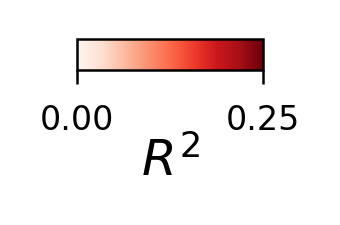

In [76]:

fig, ax = plt.subplots(figsize=(0.6, 0.2), dpi=400)
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', )
cb1.set_label(r'$R^2$', labelpad=0)
fig.savefig(save_dir / "umap_scale.pdf", bbox_inches="tight", transparent=True,)

#### Visualizing UMAP interactively

Useful to hover and confirm certain compounds

In [82]:
np.argwhere(concat_name_vec == "mills_89")

array([[1003]])

In [76]:
ax_sizes = (3, 3)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25



out = ax.scatter(umap_embeds[not_mills, 0], 
                 umap_embeds[not_mills, 1], 
                 color="#7D8FB9",
                 edgecolors='black',
                 s=4,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.4,
                )
labels=[f"target: {ind}: {concat_name_vec[ind]}" for ind, mask in enumerate(not_mills) if mask]
tooltip = mpld3.plugins.PointLabelTooltip(out, labels=labels)
mpld3.plugins.connect(fig, tooltip)

out = ax.scatter(umap_embeds[is_mills, 0], 
                 umap_embeds[is_mills, 1], 
                 c=mills_r2_vec,
                  cmap="Reds",
                 vmin=vmin,
                 vmax=vmax,
                 edgecolors='black',
                 s=5,
                 linewidth=0.1,
                 alpha=0.8,
                 zorder=1
                )

labels=[f"target: {ind}: {concat_name_vec[ind]}" for ind, mask in enumerate(is_mills) if mask]
tooltip = mpld3.plugins.PointLabelTooltip(out, labels=labels)
mpld3.plugins.connect(fig, tooltip)



out = ax.scatter(umap_embeds[novel_form, 0], 
                 umap_embeds[novel_form, 1], 
                 c=mills_r2_vec[novel_form_mills],
                 cmap="Reds",
                 vmin=vmin,
                 vmax=vmax,
                 edgecolors='orange',
                 marker="o",
                 s=5,
                 linewidth=0.5,
                 alpha=0.8,
                 zorder=2
                )
labels=[f"target: {ind}: {concat_name_vec[ind]}" for ind, mask in enumerate(novel_form) if mask]
tooltip = mpld3.plugins.PointLabelTooltip(out, labels=labels)
mpld3.plugins.connect(fig, tooltip)



ax.set_xticks([])
ax.set_yticks([])

legend = ax.legend(loc="lower left",
                   frameon=True, facecolor="white", fancybox=False, framealpha=1.0,
                   markerscale=2.5,  #bbox_to_anchor=(-0.5, 0.95)  , #
                   ncol=1,labelspacing=0., handletextpad=-0.1)
frame = legend.get_frame()
frame.set_linewidth(0.)
# frame.set_edgecolor("black")
for lh in legend.legendHandles:
    lh.set_alpha(1)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
mpld3.display()

# fig.savefig(save_dir / "umap_dist.png", bbox_inches="tight", transparent=True, dpi=400)

No handles with labels found to put in legend.
/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/mpld3/mplexporter/exporter.py:179: UserWarning: Legend element <matplotlib.offsetbox.HPacker object at 0x7ff71436eb20> not impemented
  warnings.warn("Legend element %s not impemented" % child)


Smi_list:
['NC(CCC(=O)O)C(=O)N1CCCC1C(=O)O', 'NC(CC(=O)O)C(=O)N1CCCC1C(=O)O', 'C1CC(N(C1)C(=O)C(CC(=O)O)N)C(=O)O', 'NC(CCC(=O)O)C(=O)N1CCCC1C(=O)N1CCCC1C(=O)O']
Ind: 1066, Name: mills_216, novel form: False, novel ikey: False, Smiles: NC(CCC(=O)O)C(=O)N1CCCC1C(=O)O
Ind: 1047, Name: mills_183, novel form: False, novel ikey: False, Smiles: NC(CC(=O)O)C(=O)N1CCCC1C(=O)O
Ind: 619, Name: nistpep_41169, novel form: False, novel ikey: False, Smiles: C1CC(N(C1)C(=O)C(CC(=O)O)N)C(=O)O
Ind: 1028, Name: mills_453, novel form: True, novel ikey: True, Smiles: NC(CCC(=O)O)C(=O)N1CCCC1C(=O)N1CCCC1C(=O)O


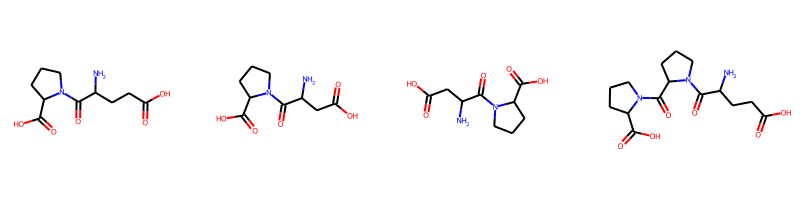

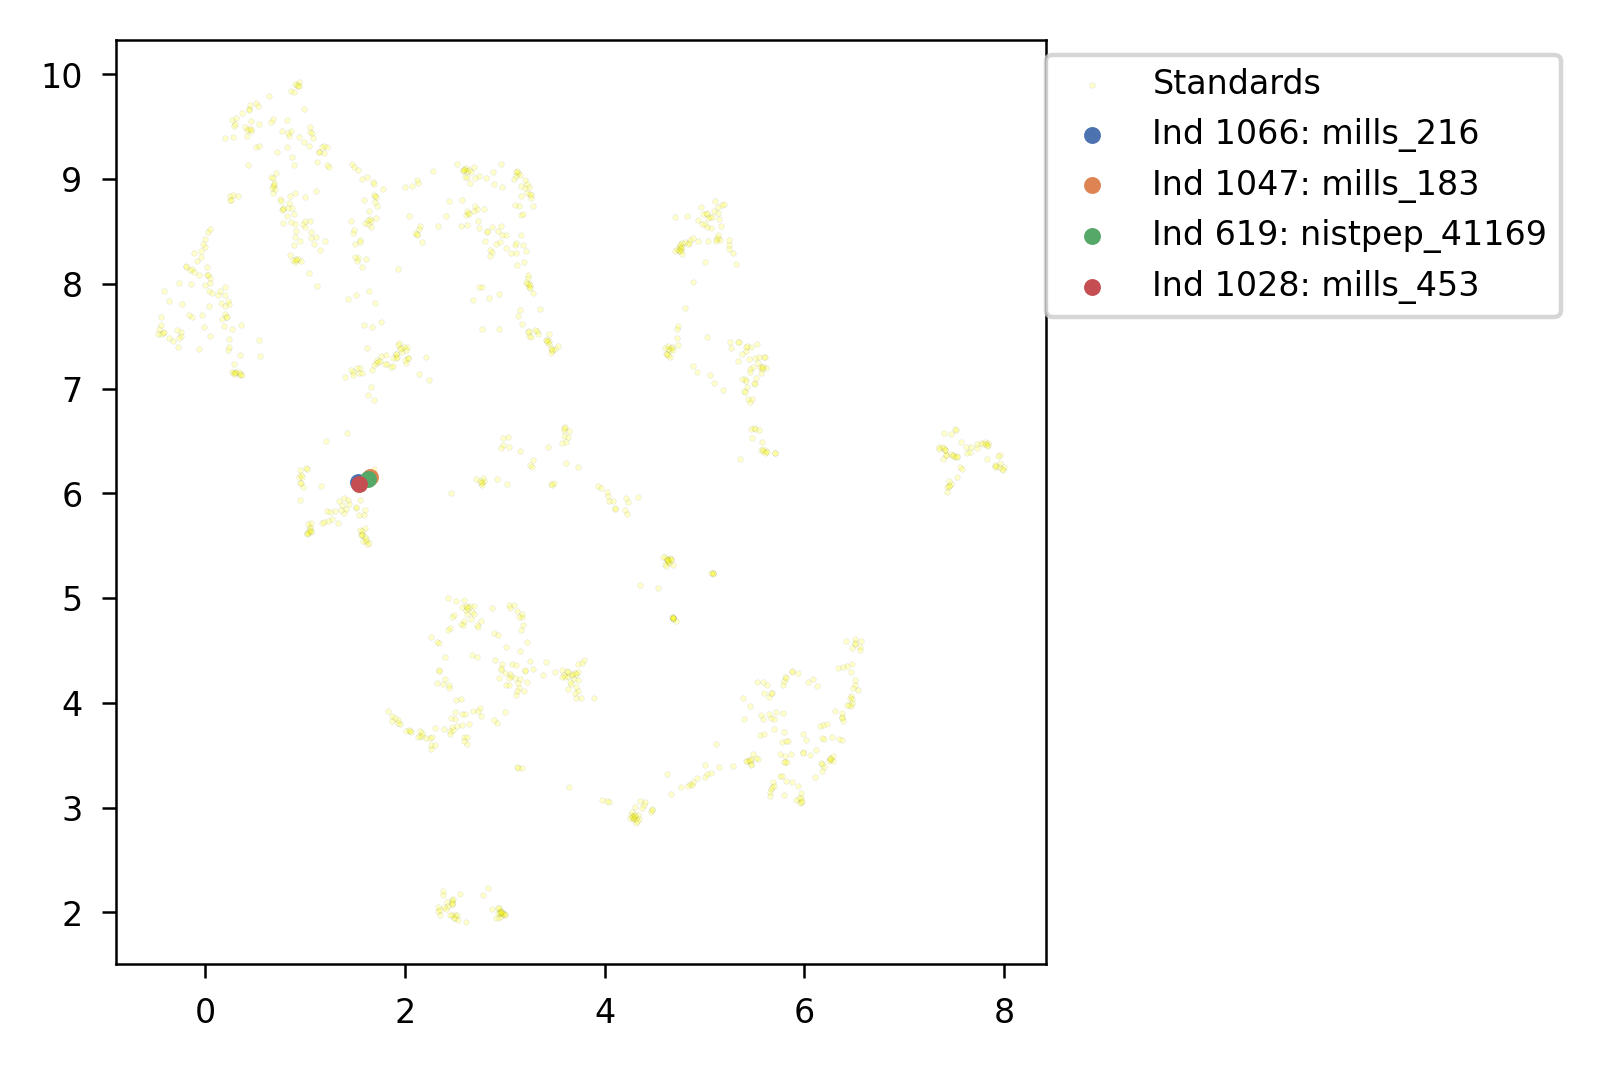

In [77]:

id_list = [1066, 1047, 619, 1028]
# id_list = [1003]
new_plot_points = umap_embeds[id_list, :]

smiles = [csi_spec_to_smiles[i] for i in concat_name_vec[id_list]]
grid = [Chem.MolFromSmiles(i) for i in smiles]
print(f"Smi_list:\n{smiles}")
entry_headers = "\n".join([
    f"Ind: {ind}, Name: {concat_name_vec[ind]}, novel form: {novel_form[ind]}, \
novel ikey: {novel_ikey[ind]}, Smiles: {csi_spec_to_smiles[concat_name_vec[ind]]}" 
    for ind in id_list])
print(entry_headers)
xlim, ylim

fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25
out = ax.scatter(umap_embeds[:, 0], 
                 umap_embeds[:, 1], 
                 label="Standards",
                 color="yellow",
                 edgecolors='black',
                 s=1,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.2)

for j in id_list:
    out = ax.scatter(umap_embeds[j, 0], 
                     umap_embeds[j, 1],
                     label=f"Ind {j}: {concat_name_vec[j]}",
                     s=5
                    )
ax.legend(loc=(1.0, 0.7))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Draw.MolsToGridImage(grid, molsPerRow=4)

Smi_list:
['CC(C)C(N)C(=O)NC(C(=O)O)C(C)O', 'CCC(C)C(N)C(=O)NC(C(=O)O)C(C)O', 'CCC(C)C(C(=O)NC(CC(=O)N)C(=O)O)N']
Ind: 1018, Name: mills_271, novel form: False, novel ikey: False, Smiles: CC(C)C(N)C(=O)NC(C(=O)O)C(C)O
Ind: 1034, Name: mills_469, novel form: False, novel ikey: False, Smiles: CCC(C)C(N)C(=O)NC(C(=O)O)C(C)O
Ind: 721, Name: nistpep_41290, novel form: False, novel ikey: False, Smiles: CCC(C)C(C(=O)NC(CC(=O)N)C(=O)O)N


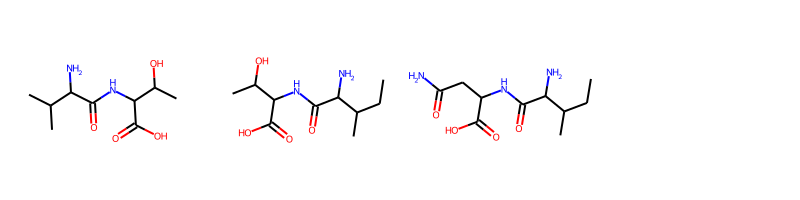

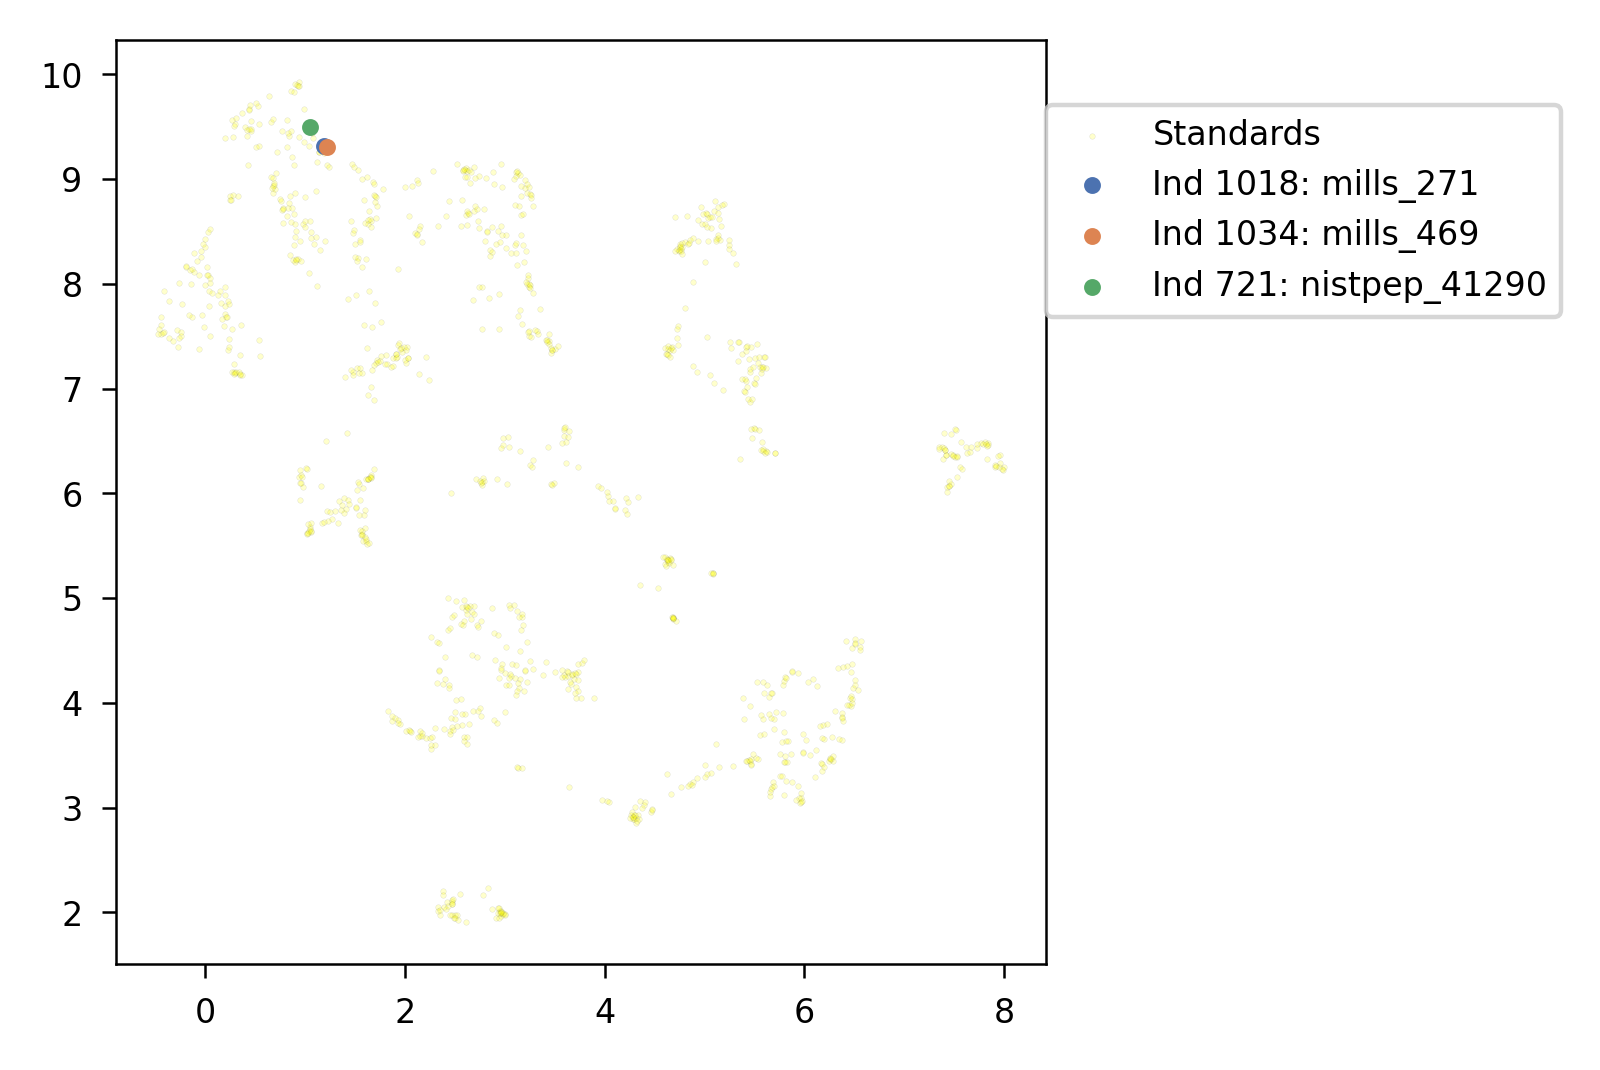

In [78]:


id_list = [1018, 1034, 721,]# 94]
new_plot_points = umap_embeds[id_list, :]

smiles = [csi_spec_to_smiles[i] for i in concat_name_vec[id_list]]
grid = [Chem.MolFromSmiles(i) for i in smiles]
print(f"Smi_list:\n{smiles}")
entry_headers = "\n".join([
    f"Ind: {ind}, Name: {concat_name_vec[ind]}, novel form: {novel_form[ind]}, \
novel ikey: {novel_ikey[ind]}, Smiles: {csi_spec_to_smiles[concat_name_vec[ind]]}" 
    for ind in id_list])
print(entry_headers)
xlim, ylim

fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25
out = ax.scatter(umap_embeds[:, 0], 
                 umap_embeds[:, 1], 
                 label="Standards",
                 color="yellow",
                 edgecolors='black',
                 s=1,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.2,
                )

for j in id_list:
    out = ax.scatter(umap_embeds[j, 0], 
                     umap_embeds[j, 1],
                     label=f"Ind {j}: {concat_name_vec[j]}",
                     s=5
                    )
ax.legend(loc=(1.0, 0.7))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Draw.MolsToGridImage(grid, molsPerRow=4)


######




Smi_list:
['NCC(=O)N1CCCC1C(=O)NCC(N)=O', 'C1CC(N(C1)C(=O)CN)C(=O)NC(CCCN=C(N)N)C(=O)O']
Ind: 1021, Name: mills_285, novel form: True, novel ikey: True, Smiles: NCC(=O)N1CCCC1C(=O)NCC(N)=O
Ind: 846, Name: nistpep_57866, novel form: False, novel ikey: False, Smiles: C1CC(N(C1)C(=O)CN)C(=O)NC(CCCN=C(N)N)C(=O)O


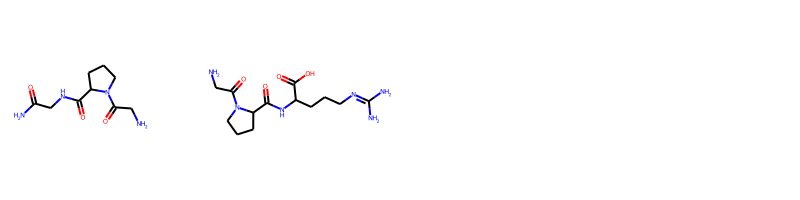

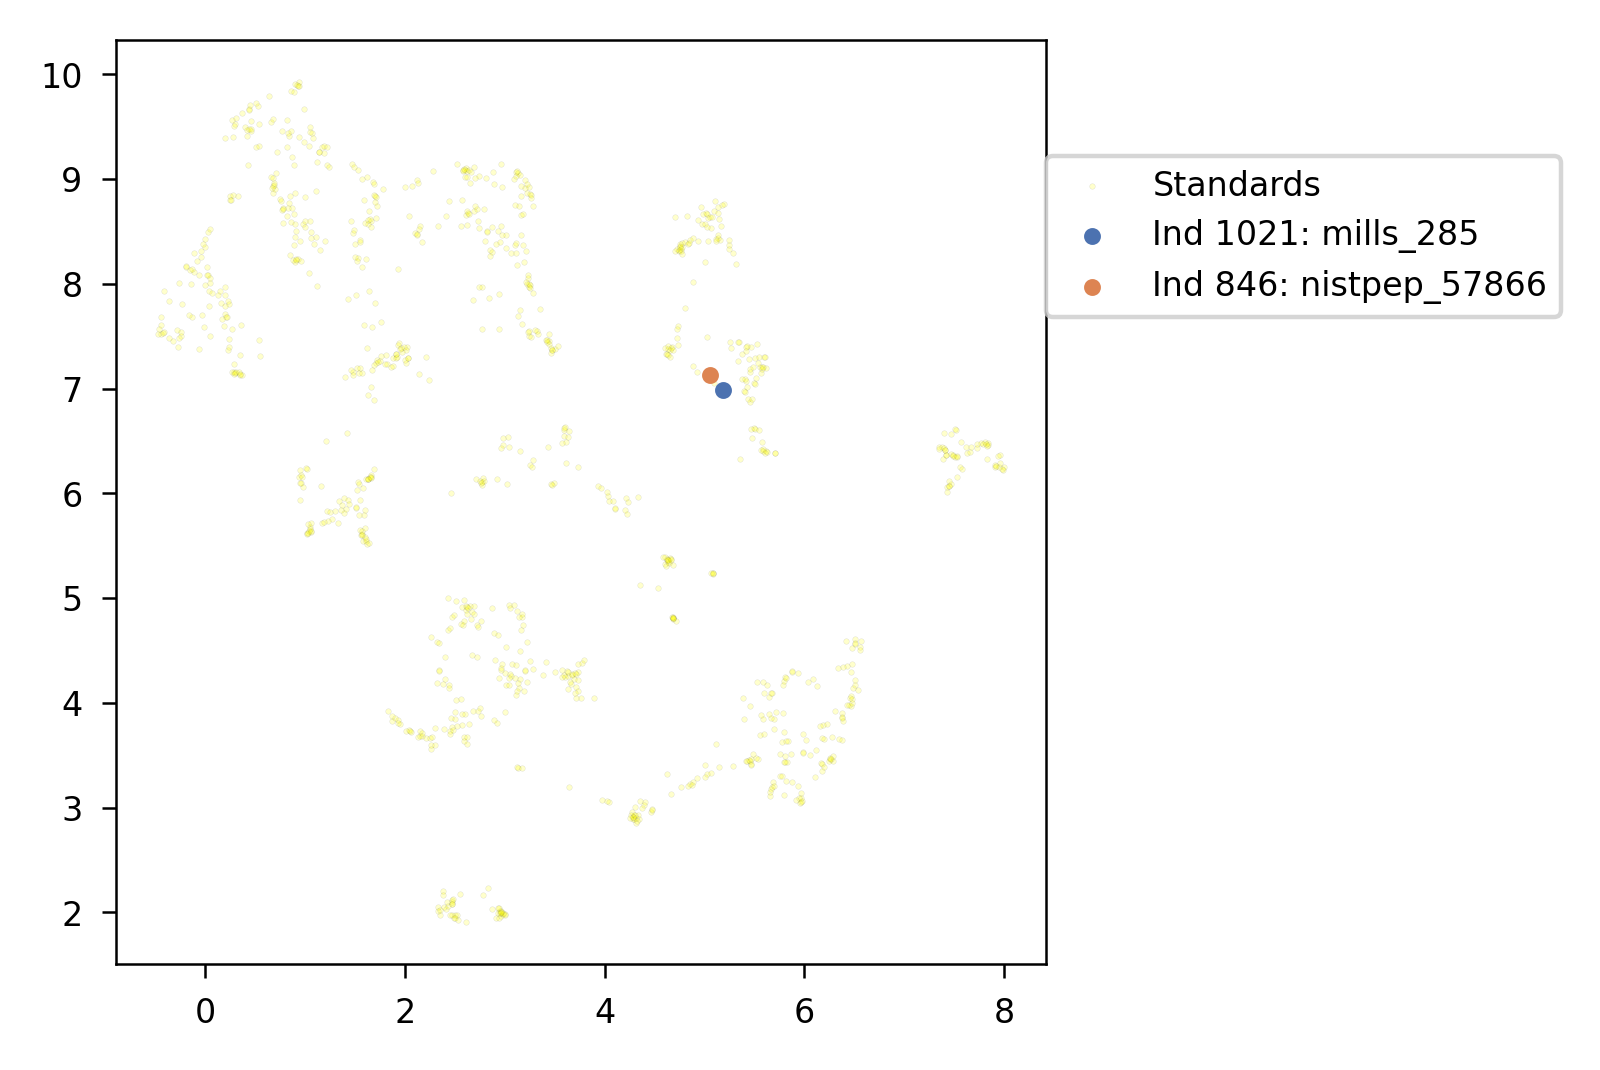

In [79]:


id_list = [1021, 846,]# 978, 1008, 530, 1093, 199,]
new_plot_points = umap_embeds[id_list, :]

smiles = [csi_spec_to_smiles[i] for i in concat_name_vec[id_list]]
grid = [Chem.MolFromSmiles(i) for i in smiles]
print(f"Smi_list:\n{smiles}")
entry_headers = "\n".join([
    f"Ind: {ind}, Name: {concat_name_vec[ind]}, novel form: {novel_form[ind]}, \
novel ikey: {novel_ikey[ind]}, Smiles: {csi_spec_to_smiles[concat_name_vec[ind]]}" 
    for ind in id_list])
print(entry_headers)
xlim, ylim

fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25
out = ax.scatter(umap_embeds[:, 0], 
                 umap_embeds[:, 1], 
                 label="Standards",
                 color="yellow",
                 edgecolors='black',
                 s=1,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.2,)

for j in id_list:
    out = ax.scatter(umap_embeds[j, 0], 
                     umap_embeds[j, 1],
                     label=f"Ind {j}: {concat_name_vec[j]}",
                     s=5
                    )
ax.legend(loc=(1.0, 0.7))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Draw.MolsToGridImage(grid, molsPerRow=4)


######




Smi_list:
['[H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O', 'NC(CCCN=C1NC(=O)C(CC(O)C(O)CO)N1)C(=O)O', 'CCCCCC(CC(=O)NO)C(=O)NC(C(C)C)C(=O)N1CCCC1CO']
Ind: 1008, Name: mills_89, novel form: True, novel ikey: True, Smiles: [H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O
Ind: 1093, Name: mills_28, novel form: True, novel ikey: True, Smiles: NC(CCCN=C1NC(=O)C(CC(O)C(O)CO)N1)C(=O)O
Ind: 530, Name: CCMSLIB00000085105, novel form: False, novel ikey: False, Smiles: CCCCCC(CC(=O)NO)C(=O)NC(C(C)C)C(=O)N1CCCC1CO


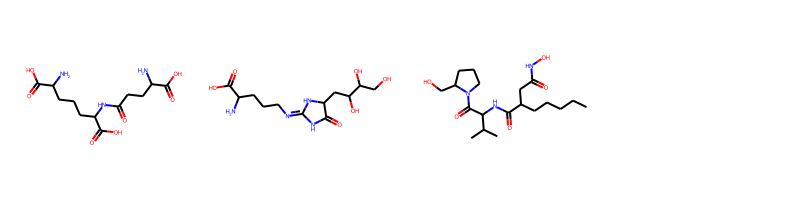

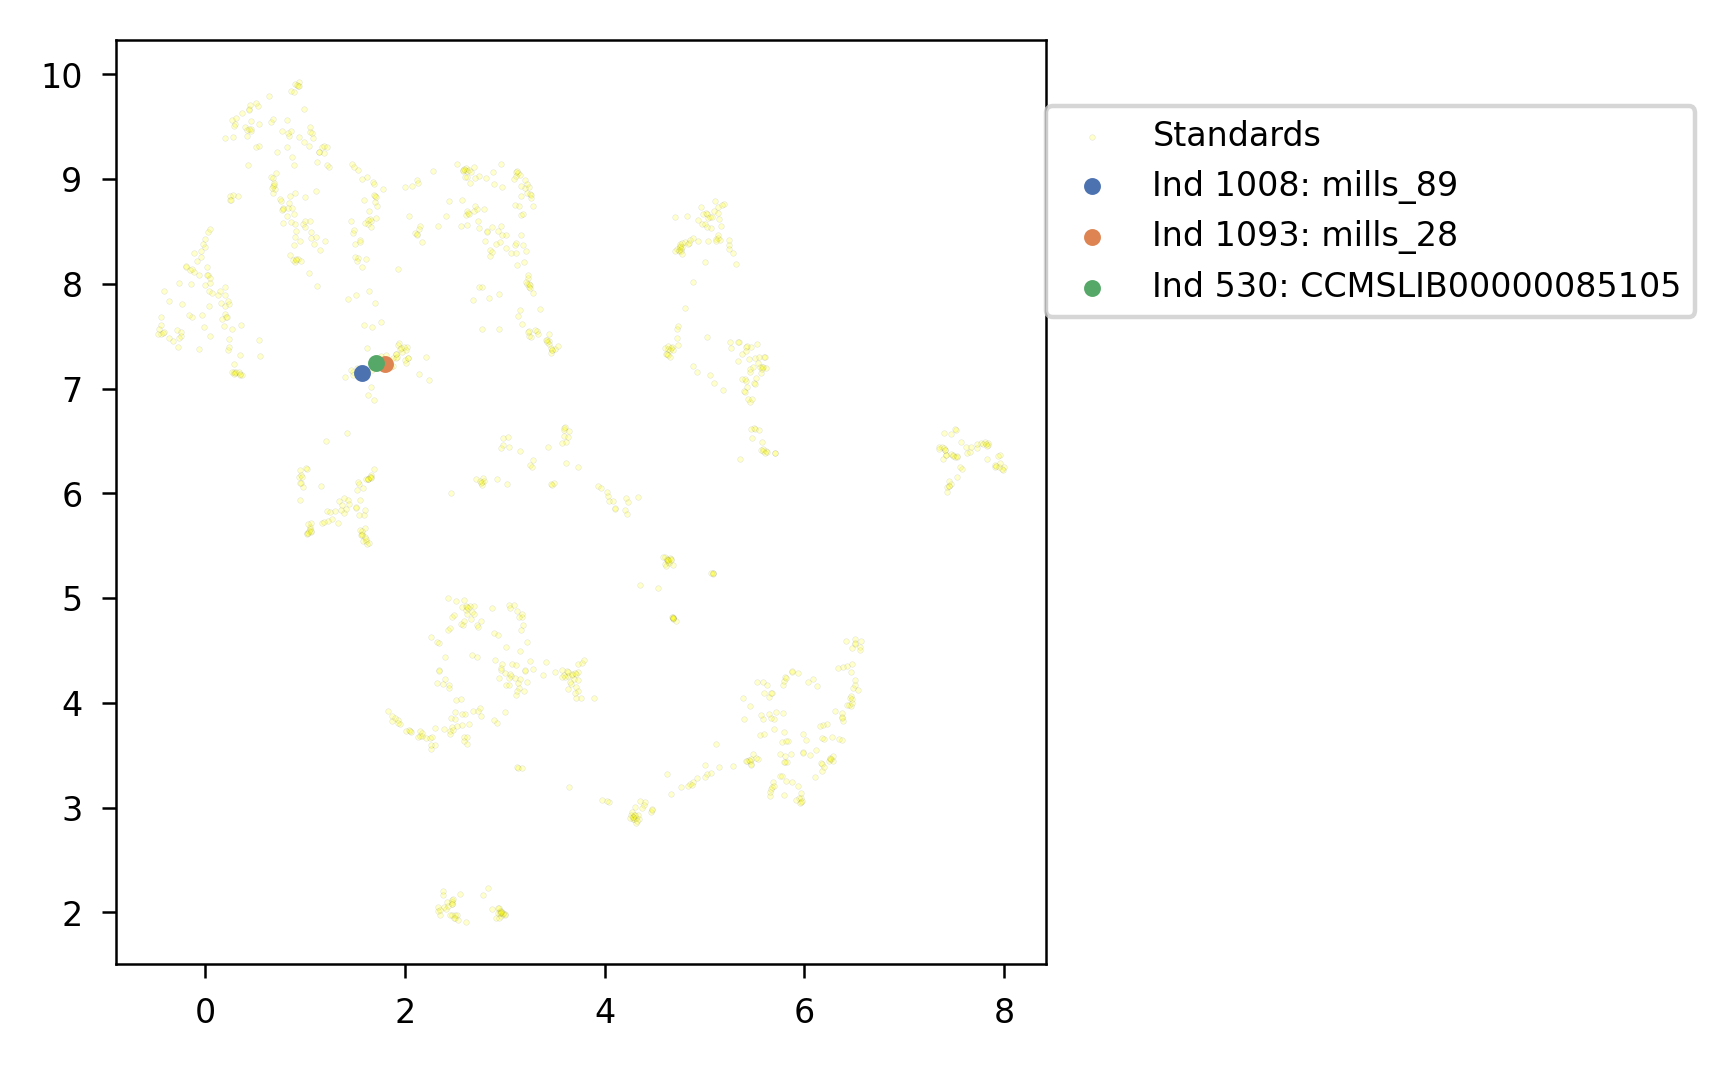

In [101]:


id_list = [1008, 1093, 530]
# id_list = np.argwhere(concat_name_vec == "mills_123").flatten()
new_plot_points = umap_embeds[id_list, :]

smiles = [csi_spec_to_smiles[i] for i in concat_name_vec[id_list]]
grid = [Chem.MolFromSmiles(i) for i in smiles]
print(f"Smi_list:\n{smiles}")
entry_headers = "\n".join([
    f"Ind: {ind}, Name: {concat_name_vec[ind]}, novel form: {novel_form[ind]}, \
novel ikey: {novel_ikey[ind]}, Smiles: {csi_spec_to_smiles[concat_name_vec[ind]]}" 
    for ind in id_list])
print(entry_headers)
xlim, ylim

fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
vmin = 0
vmax = 0.25
out = ax.scatter(umap_embeds[:, 0], 
                 umap_embeds[:, 1], 
                 label="Standards",
                 color="yellow",
                 edgecolors='black',
                 s=1,
                 linewidth=0.05,
                 zorder=0,
                 alpha=0.2,
                )

for j in id_list:
    out = ax.scatter(umap_embeds[j, 0], 
                     umap_embeds[j, 1],
                     label=f"Ind {j}: {concat_name_vec[j]}",
                     s=5
                    )
ax.legend(loc=(1.0, 0.7))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

Draw.MolsToGridImage(grid, molsPerRow=4)


######




### Plot specs

In [115]:
# sub_names_mills=["mills_285", "mills_28"]
sub_names_mills=["mills_89", "mills_453"]
sub_names_mills = ['mills_89', 'mills_119', 'mills_111']
sub_names_mills = ['mills_89', "mills_285"] #, 'mills_247', 'mills_123']

In [116]:
# Read in MGF
mgf_file = "../data/raw/mills/Mills_mzxml/gnps_fbn_export.mgf"
out_specs = utils.parse_spectra_mgf(mgf_file)
mills_specs = {f"mills_{i[0]['FEATURE_ID']}": i for i in out_specs}

3980it [00:00, 10611.21it/s]


In [126]:
## Load in specs
name_to_spec = {}
keep_peaks = 30
for j in sub_names_mills:
    spec_dict = defaultdict(lambda : 0)
    spec_meta, spec = mills_specs[j]
    for s in spec: 
        for m, i in s[1]:
            spec_dict[np.round(m,4)] += i
    full_spec = np.array([(k,v) for k,v in spec_dict.items()])
    full_spec[:, 1] = full_spec[:, 1] / np.max(full_spec[:, 1])

    new_order = np.argsort(full_spec[:, 1])[::-1]
    full_spec = full_spec[new_order][:keep_peaks, :]
    name_to_spec[j] = full_spec
    ## merge these further

In [127]:
utils.form_from_smi("[H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O")

'C12H21N3O7'

mills_89 [H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O


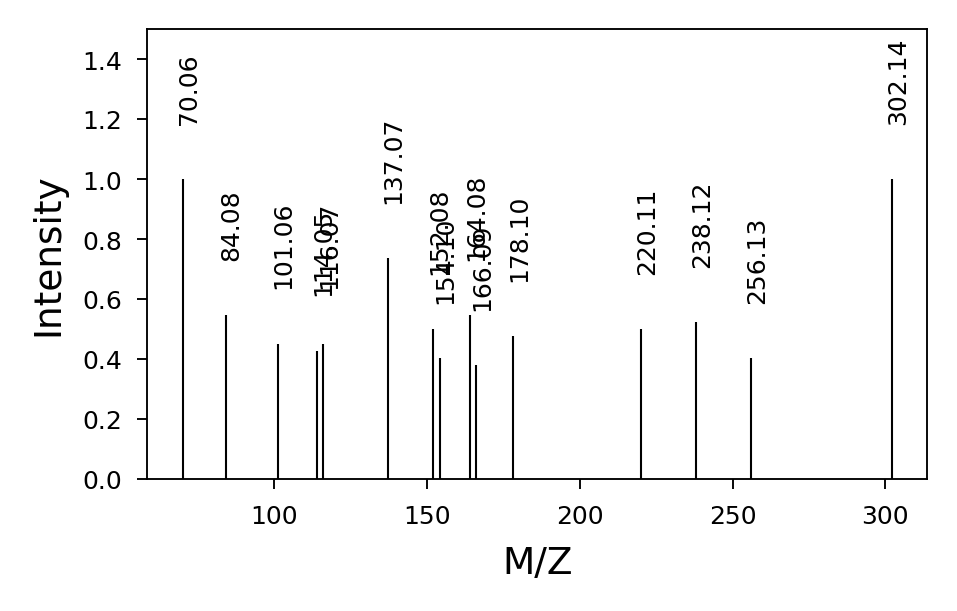

mills_285 NCC(=O)N1CCCC1C(=O)NCC(N)=O


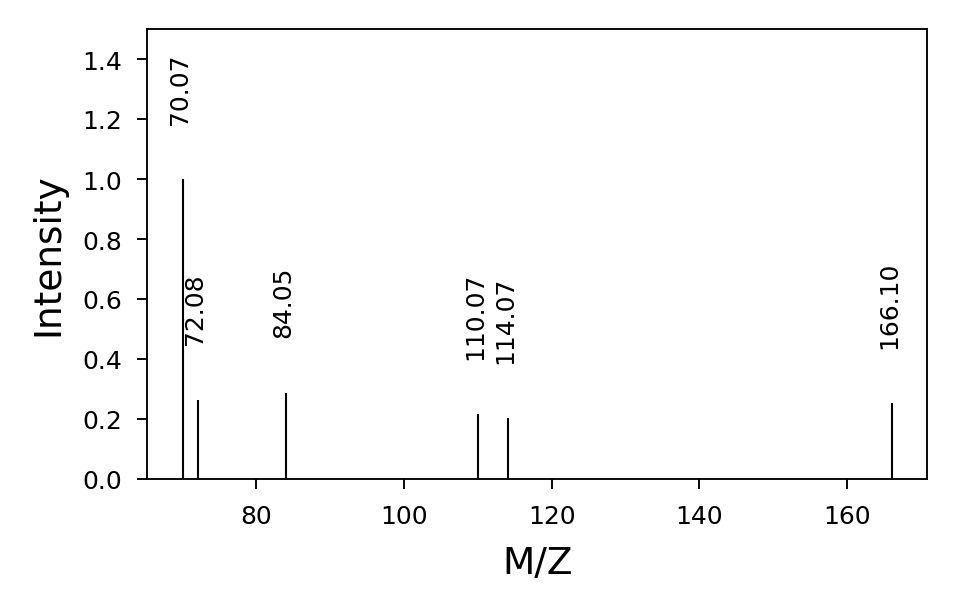

In [128]:
# Export specs
# Create plot
spec_dir = save_dir / "spectra"
spec_dir.mkdir(exist_ok=True)

for name, mz in name_to_spec.items():
    mol = Chem.MolFromSmiles(csi_spec_to_smiles[name])
    export_mol(mol, spec_dir / f"{name}_smiles.pdf")
    ax_size = (2.6,1.5)
    fig = plt.figure(figsize=ax_size, dpi=300)
    ax = fig.gca()
    for m, i in mz:
        ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)
        txt = ax.text(x=m-2,  y=i + 0.2, s = f"{m:0.2f}", fontsize=6, rotation=90) 
        # txt.set_bbox(dict(facecolor='white', alpha=1., edgecolor='none'))
    with open(spec_dir / f"{name}.txt", "w") as fp:
        fp.write(csi_spec_to_smiles[name] + "\n")
        fp.write("\n".join([" ".join([str(j) for j in row]) for row in mz]))


    ax.set_xlabel("M/Z")
    ax.set_ylabel("Intensity")
    ax.set_ylim([0,1.5])
    # ax.set_title(f"Spectra: {name}")
    set_size(*ax_size)
    print(name, csi_spec_to_smiles[name])
    plt.savefig(spec_dir / f"{name}_out_spec_{csi_spec_to_smiles[name]}.pdf", bbox_inches="tight", transparent = True)
    plt.show()

In [134]:
temp_smi = ("[H]C(N)(CCCC(NC(=O)CCC([H])(N)C(=O)O)C(=O)O)C(=O)O")
# Convert to molecule, then inchi, then molecule
mol = Chem.MolFromSmiles(temp_smi)
# To inchi
inchi = Chem.MolToInchi(mol)
# to mol
mol = Chem.MolFromInchi(inchi)
# to smiles
smi = Chem.MolToSmiles(mol)
smi

'NC(CCCC(N=C(O)CCC(N)C(=O)O)C(=O)O)C(=O)O'

In [135]:
# Use CFM ID to extract relevant fragmentation labels and export them to pdf 
name_to_fragments = {
    # "mills_28": ["CCCC#[NH+]", "CC=CC(=[NH2+])C(O)O", "[NH3+]C#CC(=O)C(O)CO", 
    #             "C[NH2+]CCC=CC(O)O", "NC(N)NCC=CC(=[NH2+])C(O)O", "[NH2+]=C1N=C(O)C(CC(O)C(O)CO)N1",
    #              "C#CC#C[NH2+]C1NC(O)C(CC(O)C(O)CO)N1", "OCC(O)CC1NC([NH2+]C=CC#CC(O)O)NC1O", "NC(O)C(CC(O)C(O)CO)NC=[NH+]C#CC#CC(O)O",
    #             "NC(N=CC#CC(=[NH2+])C(O)O)NC(O)CCC(O)C(O)CO"],
    "mills_285": ["C1=[NH+]CCC1", "C1CC[NH2+]C1", "C#CC(=O)[NH2+]C"],
    "mills_89": ["C#CC=C([NH3+])C(O)O" , "C#CCC([NH3+])C(O)O", "NC(CCC(O)=NC(=CC#CC(=[NH2+])CO)C(O)O)C(O)O", "CCC#CC(O)[OH2+]", "CCCC#[NH+]", "NC(CCC(O)NC#CC#CC(=[NH2+])CO)C(O)O"]
}

In [136]:
for k,v in name_to_fragments.items(): 
    for smi in v:
        mol = Chem.MolFromSmiles(smi)
        mol_weight = utils.ExactMolWt(mol)
        print(mol_weight)
        output_name = spec_dir / f"{k}_{mol_weight:0.2f}_{smi}.pdf"
        export_mol(mol, output_name)

70.06512567608999
72.08077574008999
84.04439023209
114.05495491609
116.07060498009
302.13466178008997
101.05970594809
70.06512567608999
256.12918247609


#### Build MAGMa annotations

This assumes we have also installed ms-pred from https://github.com/samgoldman97/ms-pred

In [129]:
from ms_pred.magma import fragmentation as fe
import  ms_pred.common as common

def draw_single_mol(frag, engine, filename):
    """Draw single molecule."""
    draw_dict = engine.get_draw_dict(frag)
    keep_atoms = draw_dict['hatoms']
    keep_bonds = draw_dict['hbonds']
    mol = draw_dict['mol']
    Chem.Kekulize(mol)
    drawing = Draw.MolToFile(mol, filename, highlightAtoms=keep_atoms, highlightBonds=keep_bonds)
    return drawing

In [130]:
csi_spec_to_smiles[name]

'NCC(=O)N1CCCC1C(=O)NCC(N)=O'

In [131]:
spec_dir = save_dir / "spectra_magma"
spec_dir.mkdir(exist_ok=True)

for name, mz in name_to_spec.items():
    smi = csi_spec_to_smiles[name]
    mol = Chem.MolFromSmiles(smi)

    mol_weight = utils.ExactMolWt(mol)
    output_name = spec_dir / f"{name}_{mol_weight:0.2f}_{smi}.pdf"

    export_mol(mol, output_name)

    # Conduct fragmentations
    engine = fe.FragmentEngine(
        mol_str=smi,
    )   
    engine.generate_fragments()
    frag_hashes, frag_inds, shift_inds, masses, scores = engine.get_frag_masses()
    updated_masses = masses + common.ion2mass["[M+H]+"]
    mdiffs = np.abs(mz[:, 0][:, None] - updated_masses[None, :])
    has_annot = mdiffs.min(-1) < 0.01

    # Get min value for each row and sort within these by scores
    min_value = mdiffs.min(-1)    
    min_score_mask = mdiffs == min_value[:, None]
    # For each row, get the index iwth the lowest score and that passes min score mask
    for i, row in enumerate(min_score_mask):
        if row.sum() > 1:
            min_score = scores[row].min()
            min_score_mask[i] = np.logical_and(min_score_mask[i],  scores == min_score)

    # Get index in each row that is true from min score mask
    annot_ind = min_score_mask.argmax(-1)
    print(annot_ind.shape, has_annot.shape)
    for m_val, ind in zip(mz[has_annot, 0], annot_ind[has_annot]):
        mass_hshift = int(engine.shift_bucket_masses[shift_inds[ind]])
        output_name = spec_dir / f"{name}_{m_val:0.2f}_{mass_hshift}.png"
        draw_single_mol(frag_inds[ind], engine, str(output_name))



(15,) (15,)
(6,) (6,)


## Cohort 2 case control analysis
Construct volcano plots for CD / UC with healthy for various compounds

In [151]:
all_compound_ids = pd.unique(melted_df_2['compound_id'].values)
compare_groups = [("Healthy_control", "CD"), ("Healthy_control", "UC")]

In [152]:
melted_df_2;
for i,j in melted_df_2.groupby("diagnosis"):
    print("Disease:", i, ": Num metabolites > 0 ", np.sum(j.groupby("compound_id").mean("inten").values > 0))

Disease:  : Num metabolites > 0  1556
Disease: CD : Num metabolites > 0  3963
Disease: Healthy_control : Num metabolites > 0  1501
Disease: IND : Num metabolites > 0  908
Disease: UC : Num metabolites > 0  3924


In [153]:
key = "compound_id"#class_results"#"class_results"
key = "class_results"#class_results"#"class_results"
all_ids = pd.unique(melted_df_2[key].values)

In [154]:
level = "class_results" 
melted_df_2 = out_name_to_df[level]

# Add thresh -- find thesh that give sus equal sized healthy and diseased cohorts
# Thresh 0.22 clearly shows the trned at the class level but it doesn't show any metabolites upregualted as individuals which is odd for UC
# Thresh 0.3 doesn't do it; maybe 0.1...
# thresh = 0.2 #0.1
thresh = 0.2 #0.1
melted_df_2_temp = melted_df_2[~pd.isna(melted_df_2['activity'])].reset_index(drop=True)
melted_df_2_temp['over_thresh'] = melted_df_2_temp['activity'] > thresh
melted_df_2_temp.pivot_table(index="diagnosis", values="over_thresh", aggfunc="mean")

,over_thresh
diagnosis,
CD,0.372549
Healthy_control,0.000000
IND,0.000000
UC,0.366667


In [155]:
# Numbers..
Counter(dict(melted_df_2_temp[['sample', 'diagnosis']].values).values())

Counter({'CD': 102, 'UC': 60, 'IND': 1, 'Healthy_control': 19})

In [156]:
102 * 0.372549, 60 * 0.3666667

(37.999998000000005, 22.000002000000002)

In [157]:

out_list = []
pseudo=1
for id_name in tqdm(all_ids): 
    compound_bool = melted_df_2_temp[key] == id_name
#     in_allowed_samples = [i in allowed_samples for i in melted_df_2['sample'].values] 
    for group_a, group_b in compare_groups:        
        group_a_bool = melted_df_2_temp['diagnosis'] == group_a 
        group_b_bool = melted_df_2_temp['diagnosis'] == group_b
        
        group_a_sel = np.logical_and(group_a_bool, compound_bool)
        group_b_sel = np.logical_and(group_b_bool, compound_bool)
        group_b_sel = np.logical_and(group_b_sel, melted_df_2_temp['activity'].values > thresh)        
        
        
        group_b_vals = melted_df_2_temp[group_b_sel].groupby('sample').mean()
        group_a_vals = melted_df_2_temp[group_a_sel].groupby('sample').mean()
    
        group_a_vals = group_a_vals['inten'].values + pseudo
        group_b_vals = group_b_vals['inten'].values + pseudo
        
        log_fold_change = np.log(np.mean(group_b_vals) / np.mean(group_a_vals))
        ttest_result = stats.ttest_ind(group_a_vals, group_b_vals, equal_var=False)
        pvalue = ttest_result[1]

        out_list.append({"compare_a" : group_a,
                         "compare_b": group_b, 
                         "compare_concat": f"{group_a}_{group_b}",
                         "log(FC)": log_fold_change, 
                         "pval": pvalue,
                         "key_id": id_name,
                         "id_type": key
                        })
volcano_df = pd.DataFrame(out_list)

100%|██████████| 178/178 [00:13<00:00, 12.88it/s]


In [158]:
for correct_method in ['bonferroni', "fdr_bh"]:
    temp = np.zeros(len(volcano_df))
    for title in pd.unique(volcano_df['compare_concat']):
        temp_mask = volcano_df['compare_concat'] == title
        all_pvals = volcano_df['pval'][temp_mask]
        temp_p = all_pvals.fillna(1)
        _reject, pval_adjust, _alph1, alph2 = multipletests(temp_p, alpha=0.05, method=correct_method)
        temp[temp_mask] = pval_adjust
    volcano_df[f'{correct_method}_log10p'] = -np.log10(temp)
    volcano_df[f'p_adjust_{correct_method}'] = temp

In [159]:
volcano_df[volcano_df['key_id'] == "Pyridine alkaloids"]
# volcano_df[volcano_df['key_id'] == "Small peptides"]

,compare_a,compare_b,compare_concat,log(FC),pval,key_id,id_type,bonferroni_log10p,p_adjust_bonferroni,fdr_bh_log10p,p_adjust_fdr_bh
36,Healthy_control,CD,Healthy_control_CD,-0.550629,0.000931,Pyridine alkaloids,class_results,0.780547,0.165750,1.859728,0.013812
37,Healthy_control,UC,Healthy_control_UC,-0.740583,0.000033,Pyridine alkaloids,class_results,2.237078,0.005793,2.237078,0.005793


In [160]:
volcano_df[volcano_df['key_id'] == "Piperidine alkaloids"]

,compare_a,compare_b,compare_concat,log(FC),pval,key_id,id_type,bonferroni_log10p,p_adjust_bonferroni,fdr_bh_log10p,p_adjust_fdr_bh
86,Healthy_control,CD,Healthy_control_CD,-1.295007,0.001366,Piperidine alkaloids,class_results,0.614022,0.243208,1.857117,0.013896
87,Healthy_control,UC,Healthy_control_UC,-1.301786,0.001344,Piperidine alkaloids,class_results,0.621122,0.239264,1.466220,0.034181


Downregulated from control: ['Pyridine alkaloids' 'Piperidine alkaloids' 'Simple oxindole alkaloids'
 'Triacylglycerols' 'Amino cyclitols' 'Unsaturated fatty acids'
 'Prenyl quinone meroterpenoids']
Upregualted from control: ['Aminoacids']
Downregulated from control: ['Purine nucleos(t)ides' 'Purine alkaloids' 'Pyridine alkaloids'
 'Piperidine alkaloids' 'Simple oxindole alkaloids' 'Primary amides'
 'Amino cyclitols' 'Fatty alcohols' 'Arteminisin' 'Macrolide lactones'
 'Ergostane steroids']
Upregualted from control: ['Simple amide alkaloids' 'Cinnamic acids and derivatives' 'Limonoids'
 'Cholane steroids' 'Bufadienolides' 'Cholestane steroids' 'Cardenolides'
 'Oplopane sesquiterpenoids' 'Botryane sesquiterpenoids'
 'Himachalane sesquiterpenoids' 'Glycosyldiacylglycerols'
 'Cyclophytane diterpenoids' 'Carotenoids (C40, β-κ)'
 'Ascomycins and Rapamycins' 'Oligomycins']


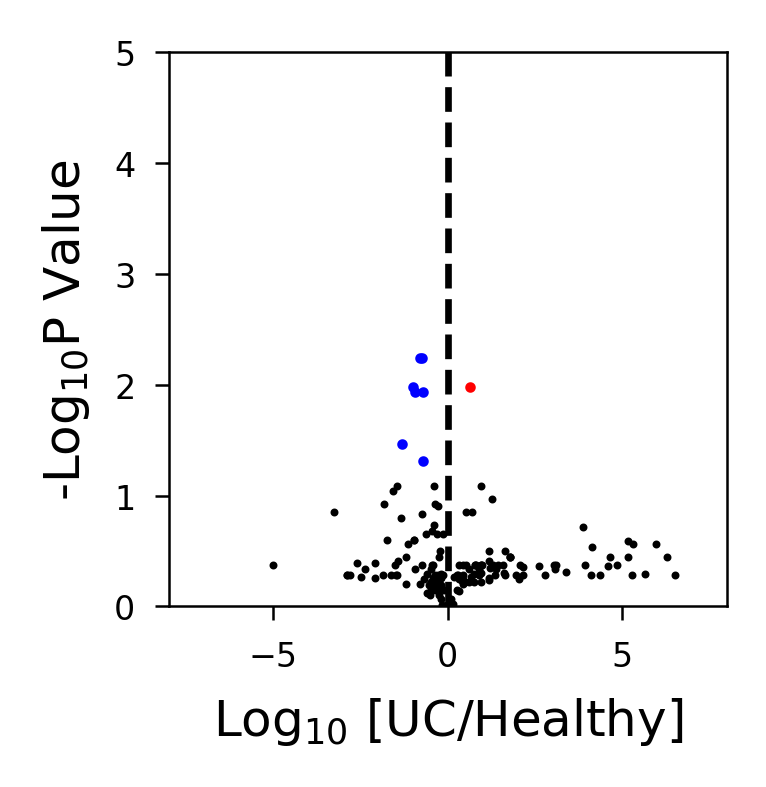

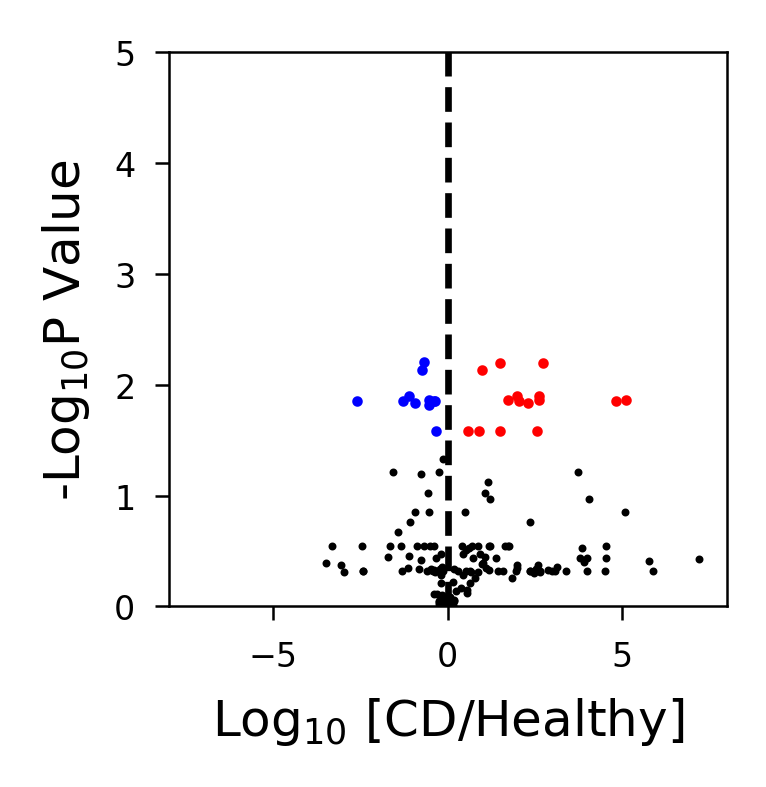

In [161]:
p_thresh = -np.log10(0.05)
fc_thresh = 0.2

#p_thresh = -np.log10(0.3)
#fc_thresh = 0.0005
p_key = "fdr_bh_log10p"
# p_key = "bonferroni_log10p"
d_to_lim={}
for compare in ["UC", "CD"]:
    compare_df = volcano_df[volcano_df['compare_b'] == compare]
    compare_p, compare_fc = compare_df[p_key], compare_df['log(FC)']
    fig = plt.figure(figsize=(1.8, 1.8), dpi=400)
    ax = plt.gca()
    ax.scatter(compare_fc, compare_p, s=0.4, color = "black")
    
    blue_mask = np.logical_and(compare_fc < -fc_thresh, compare_p > p_thresh)
    print("Downregulated from control:", compare_df["key_id"][blue_mask].values)
    ax.scatter(compare_fc[blue_mask], compare_p[blue_mask], s=1.2, color = "blue")
    
    
    red_mask = np.logical_and(compare_fc > fc_thresh, compare_p > p_thresh)
    print("Upregualted from control:", compare_df["key_id"][red_mask].values)
    ax.scatter(compare_fc[red_mask], compare_p[red_mask], s=1.2, color = "red")

    log_10_str = r"Log$_{10}$"
    ax.axvline(x=0, linestyle="--", color="black")
    ax.set_xlabel(fr"{log_10_str} [{compare}/Healthy]")
    ax.set_ylabel(f"-{log_10_str}P Value")
    d_to_lim[compare] = ax.get_xlim(), ax.get_ylim()

    ax.set_xlim([-8,8])
    ax.set_ylim([0, 5])
#     ax.set_title(f"{compare} vs. control")
#     legend.get_frame().set_facecolor('none')
    fig.savefig(save_dir / f"volcano_class_{compare}.pdf", bbox_inches="tight", 
                transparent=True)

### Repeat volcano using labeled points

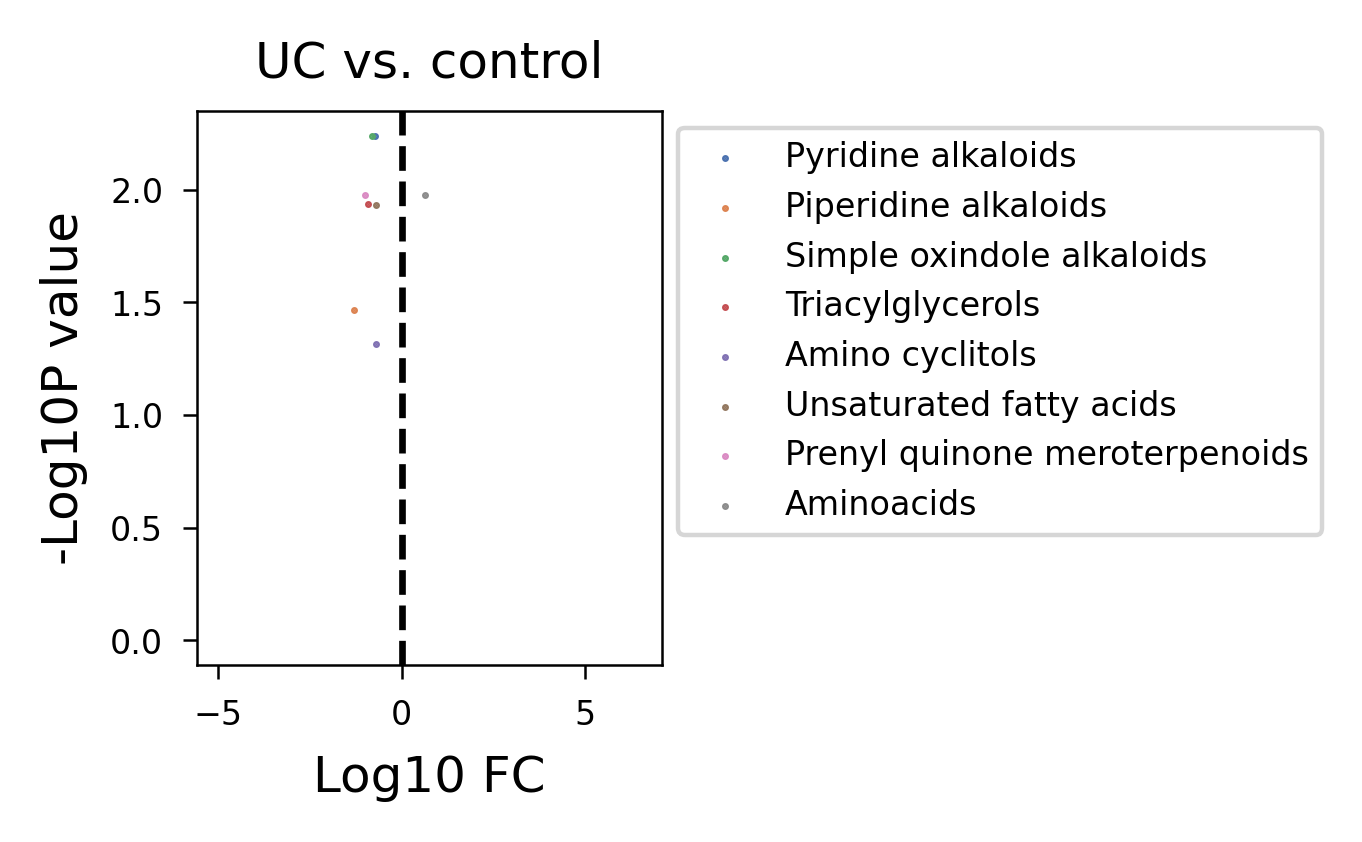

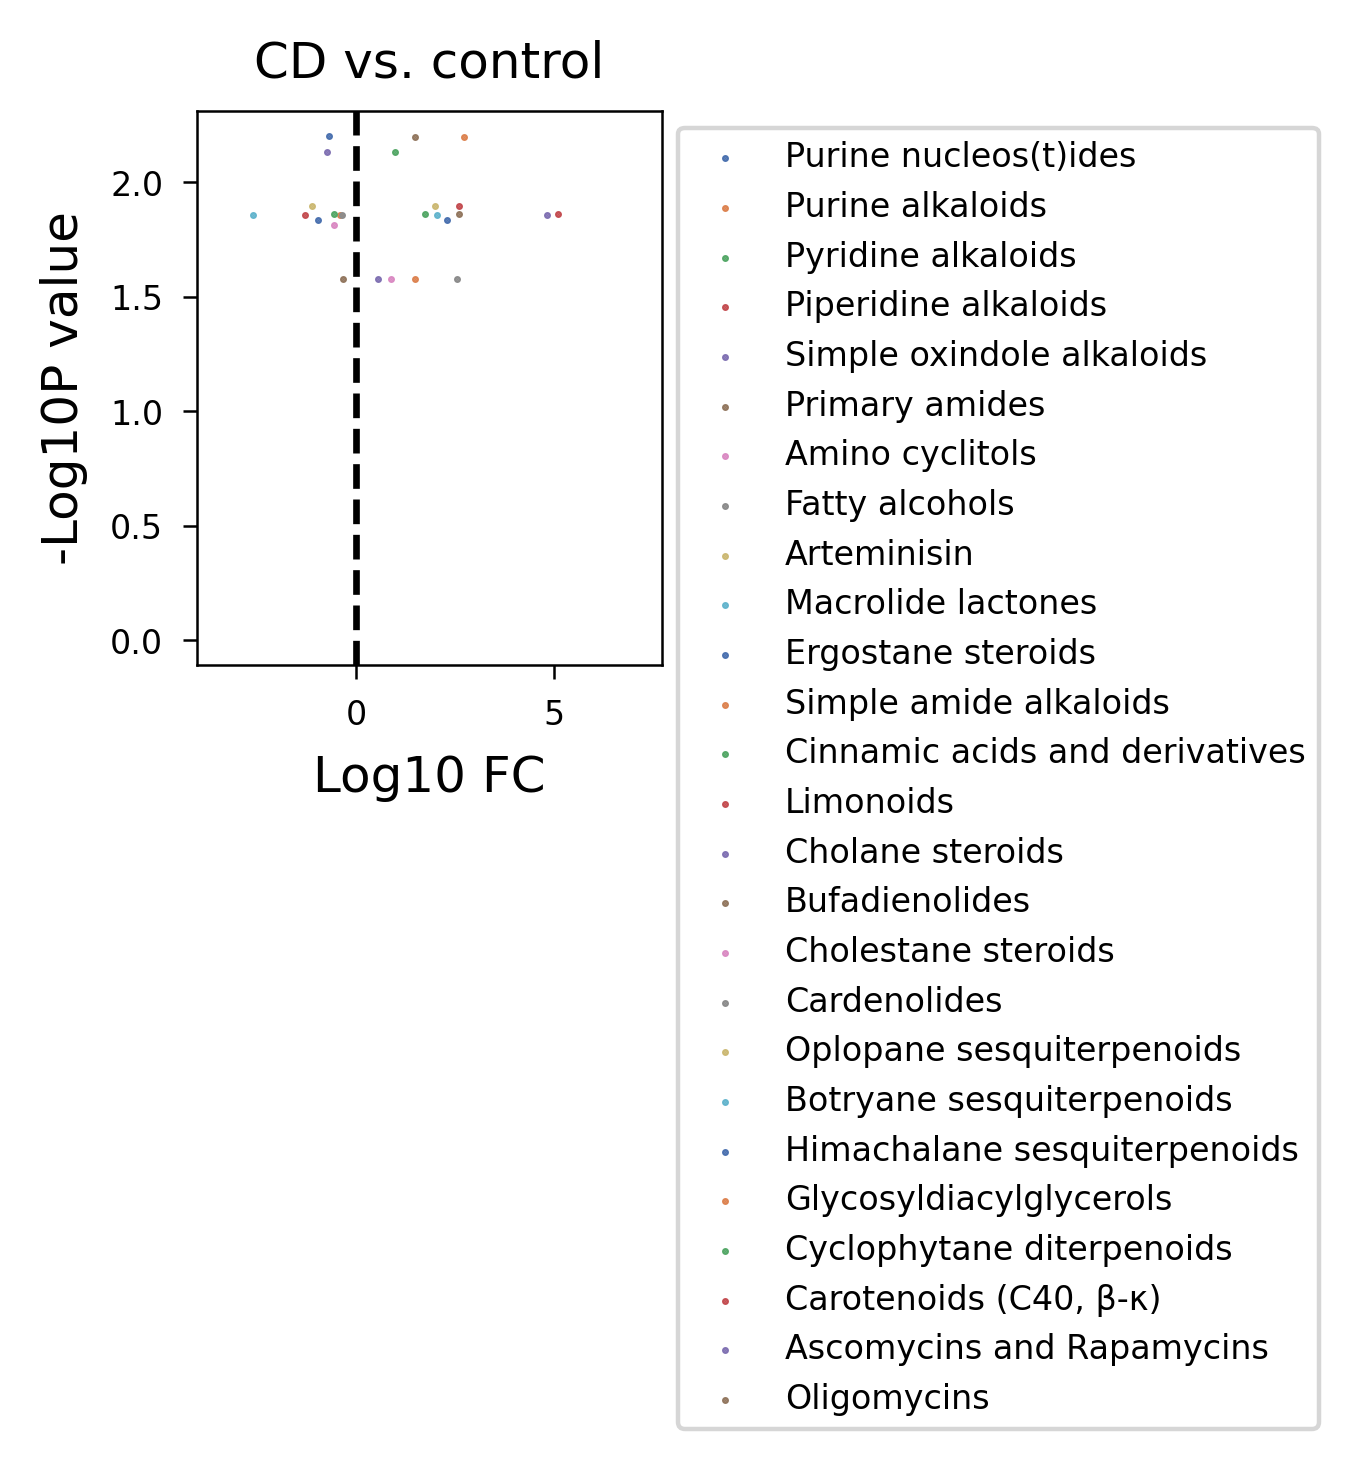

In [162]:
p_key = "fdr_bh_log10p"
# p_key = "bonferroni_log10p"
for compare in ["UC", "CD"]:
    compare_df = volcano_df[volcano_df['compare_b'] == compare]
    compare_p, compare_fc = compare_df[p_key], compare_df['log(FC)']
    plt.figure(figsize=(1.5, 1.8), dpi=400)
    ax = plt.gca()    
    blue_mask = np.logical_and(compare_fc < -fc_thresh, compare_p > p_thresh)
    for ind, m in enumerate(blue_mask):
        if not m: continue
        name = compare_df["key_id"].values[ind]
        ax.scatter(compare_fc.values[ind], compare_p.values[ind], s=0.2,label=name)# color = "blue")
        
    red_mask = np.logical_and(compare_fc > fc_thresh, compare_p > p_thresh)
    for ind, m in enumerate(red_mask):
        if not m: continue
        name = compare_df["key_id"].values[ind]
        ax.scatter(compare_fc.values[ind], compare_p.values[ind], s=0.2,label=name)# color = "blue")

    
    ax.axvline(x=0, linestyle="--", color="black")
    ax.set_xlabel("Log10 FC")
    ax.set_ylabel("-Log10P value")
    ax.set_xlim(d_to_lim[compare][0])
    ax.set_ylim(d_to_lim[compare][1])
    ax.set_title(f"{compare} vs. control")
    ax.legend(bbox_to_anchor=(1.0,1.0))

### Looking at boxplots _by class_

In [163]:
key = "class_results"
id_names = ["Piperidine alkaloids", "Pyridine alkaloids"]#, "Amino cyclitols"]
res_dict = {}
valid_keys = [ "Healthy_control", "UC", "CD" ]
for id_name in id_names:
    res_dict[id_name] = {}
    for k in valid_keys:
        logical_id = melted_df_2_temp[key] == id_name
        logical_diagnosis = melted_df_2_temp['diagnosis'] == k
        sel_bool = np.logical_and(logical_id, logical_diagnosis)
        if k != "Healthy_control":
            sel_bool = np.logical_and(sel_bool, melted_df_2_temp['activity'].values > thresh)
        res_dict[id_name][k] = melted_df_2_temp[sel_bool].groupby('sample').sum()['inten'].values




19 Healthy_control
22 UC
38 CD
19 Healthy_control
22 UC
38 CD


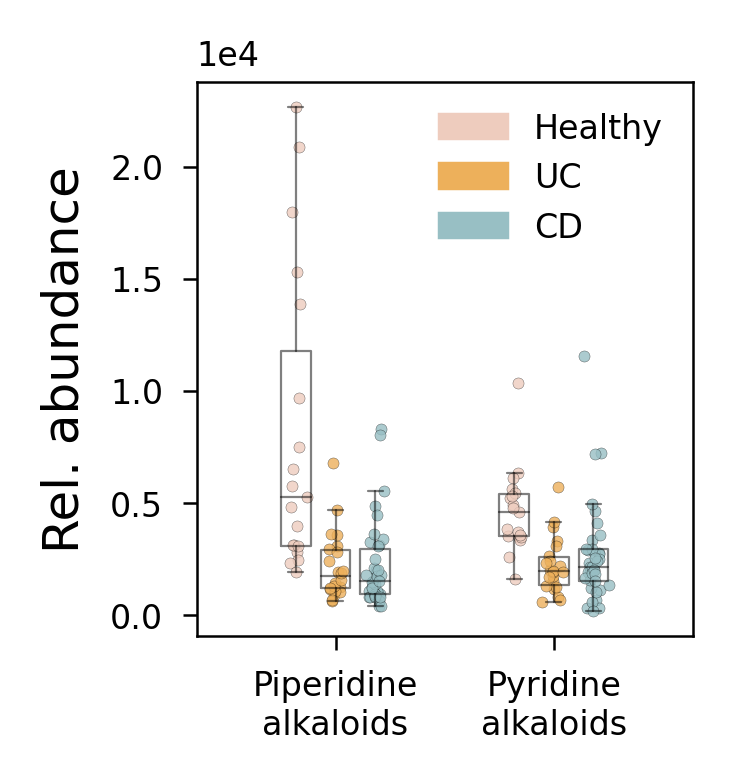

In [164]:
figsize=(1.6, 1.8)
fig = plt.figure(figsize=figsize, dpi=400)
boxprops = {"color":"black", "alpha":0.5, "linewidth":0.4}
ax = fig.gca()
tick_pos =  []
key_to_label = {"UC": "UC", "Healthy_control": "Healthy", "CD": "CD"}
key_to_color = {"UC": uc_color, "Healthy_control": healthy_color, "CD": cd_color}

for id_ind, id_name in enumerate(id_names):
    base_pos = id_ind*1.1
    ind_offsets = 0.2
    for ind, k in enumerate(valid_keys):
        y_vals = res_dict[id_name][k] + 1
        x_vals = np.ones(len(y_vals)) * ind
        x_jitter = np.random.normal(size=x_vals.shape, scale=0.02)
        x_pos = base_pos - ind_offsets + ind*ind_offsets
        ax.boxplot(positions=[x_pos], x=y_vals, showfliers=False, 
                   medianprops=boxprops,
                   boxprops=boxprops,
                   capprops=boxprops,
                   whiskerprops=boxprops
                  )
        print(len(y_vals), k)
        ax.scatter(x=x_pos + x_jitter, y=y_vals, s = 4, color=key_to_color.get(k),
                  edgecolor="black", linewidth=0.06, alpha=0.8, label=key_to_label.get("k"))
    tick_pos.append(base_pos)
ax.set_xticks(tick_pos)
ax.set_xticklabels([j.replace(" ", "\n") for j in id_names], rotation=0)
ax.set_ylabel("Rel. abundance")
# ax.set_title(f"{id_name}")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ax.set_yscale("log")
# ax.set_ylim([-2,1000])
# set_size(*figsize)
handles = []
for k in valid_keys:
    patch = mpatches.Patch(color=key_to_color.get(k), label=key_to_label.get(k), )
    handles.append(patch)
legend = ax.legend(handles=handles, loc='upper right', frameon=False, facecolor="none", 
                   fancybox=False, fontsize=6)

fig.savefig(save_dir / "Piperidine_boxplot.pdf", bbox_inches="tight", transparent=True)

### Plotting number of metabolites and number novel for each class

In [165]:
keys = ['Piperidine alkaloids', 'Pyridine alkaloids']
out_list = {}
for key in keys:
    id_names = pred_cls_to_names_hmdb[key]
    
#     len(id_names) print(id_names)
    smis = [id_to_smi[id_] for id_ in id_names]
    ikeys_temp = [utils.inchikey_from_smiles(i) for i in smis]
    novel_ikeys = [i not in csi_ikeys for i in ikeys_temp]
    forms = [utils.form_from_smi(i) for i in smis]
    novel_forms = [f not in csi_formulae  for f in forms]
    novel_mills = np.array(id_names)[novel_ikeys]
    print(novel_mills)
    entry = {"num_ids": len(id_names), "num_dup": len(id_names) - np.sum(novel_ikeys),  "num_novel":  np.sum(novel_ikeys), "key": key}
    out_list[key] = entry
out_list

['mills_1131' 'mills_931' 'mills_1580' 'mills_1274' 'mills_961'
 'mills_491' 'mills_1248' 'mills_1249' 'mills_1115']
['mills_380' 'mills_660' 'mills_1126' 'mills_1081' 'mills_126' 'mills_880'
 'mills_481' 'mills_509' 'mills_1763' 'mills_1772' 'mills_1179'
 'mills_564' 'mills_994' 'mills_154' 'mills_1510' 'mills_441']


{'Piperidine alkaloids': {'num_ids': 14,
  'num_dup': 5,
  'num_novel': 9,
  'key': 'Piperidine alkaloids'},
 'Pyridine alkaloids': {'num_ids': 19,
  'num_dup': 3,
  'num_novel': 16,
  'key': 'Pyridine alkaloids'}}

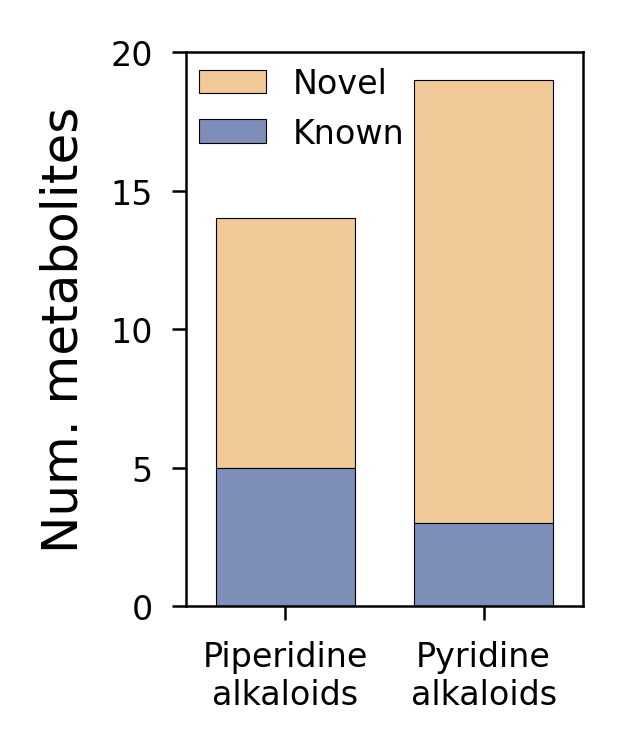

In [166]:
figsize=(1.28, 1.8)
fig = plt.figure(figsize=figsize, dpi=400)

known = [out_list[keys[0]]['num_dup'], out_list[keys[1]]['num_dup']]
novel = [out_list[keys[0]]['num_novel'], out_list[keys[1]]['num_novel']]

ax = fig.gca()
ax.bar([0, 1], novel ,label="Novel", 
       color="#F2CA9A", edgecolor="black", linewidth=0.2, bottom=known, width=0.7)
ax.bar([0, 1], known, label="Known", 
       color="#7D8FB9", edgecolor="black", linewidth=0.2,width=0.7)
ax.set_xticks([0,1])

ax.set_xticklabels([k.replace(" ", "\n") for k in keys])
ax.set_yticks(np.arange(0,21,5))
ax.set_yticklabels(np.arange(0,21,5))
ax.set_ylabel("Num. metabolites")
ax.set_xlim([-0.5,1.5])


# ax.set_xticks(tick_pos)
# ax.set_xticklabels([j.replace(" ", "\n") for j in id_names], rotation=0)
# ax.set_ylabel("Rel. abundance")
# # ax.set_title(f"{id_name}")
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# # ax.set_yscale("log")
# # ax.set_ylim([-2,1000])
# # set_size(*figsize)
# handles = []
# for k in valid_keys:
#     patch = mpatches.Patch(color=key_to_color.get(k), label=key_to_label.get(k), )
#     handles.append(patch)
legend = ax.legend(loc=(0,0.8), frameon=False, facecolor="none", 
                   fancybox=False, fontsize=6)

fig.savefig(save_dir / "Num_metabolites.pdf", bbox_inches="tight", transparent=True)

### Volcano of individual metabolites for piperidine and pyridine

In [167]:
level = "compound_id" 
melted_df_2 = out_name_to_df[level]

# Add thresh -- find thesh that give sus equal sized healthy and diseased cohorts
# Thresh 0.22 clearly shows the trned at the class level but it doesn't show any metabolites upregualted as individuals which is odd for UC
# Thresh 0.3 doesn't do it; maybe 0.1...
# thresh = 0.2 #0.1
thresh = 0.2 #0.1
melted_df_2_temp = melted_df_2[~pd.isna(melted_df_2['activity'])].reset_index(drop=True)
melted_df_2_temp['over_thresh'] = melted_df_2_temp['activity'] > thresh
key="compound_id"
melted_df_2_temp.pivot_table(index="diagnosis", values="over_thresh", aggfunc="mean")

,over_thresh
diagnosis,
CD,0.372549
Healthy_control,0.000000
IND,0.000000
UC,0.366667


In [168]:
key="compound_id"
all_ids=pd.unique(melted_df_2_temp[key])
impt_classes=['Piperidine alkaloids', 'Pyridine alkaloids', "Amino cyclitols"]
all_ids = []
impt_id_to_cls = {}
for cls in impt_classes:
    all_ids.extend(pred_cls_to_names_hmdb[cls])
    impt_id_to_cls.update({i: cls for i in pred_cls_to_names_hmdb[cls]})


In [169]:

out_list = []
pseudo=1
for id_name in tqdm(all_ids): 
    compound_bool = melted_df_2_temp[key] == id_name
#     in_allowed_samples = [i in allowed_samples for i in melted_df_2['sample'].values] 
    for group_a, group_b in compare_groups:        
        group_a_bool = melted_df_2_temp['diagnosis'] == group_a 
        group_b_bool = melted_df_2_temp['diagnosis'] == group_b
        
        group_a_sel = np.logical_and(group_a_bool, compound_bool)
        group_b_sel = np.logical_and(group_b_bool, compound_bool)
        group_b_sel = np.logical_and(group_b_sel, melted_df_2_temp['activity'].values > thresh)        
        
        
        group_b_vals = melted_df_2_temp[group_b_sel]#.groupby('sample').mean()
        group_a_vals = melted_df_2_temp[group_a_sel]#.groupby('sample').mean()
        group_a_vals = group_a_vals['inten'].values + pseudo
        group_b_vals = group_b_vals['inten'].values + pseudo
        log_fold_change = np.log(np.mean(group_b_vals) / np.mean(group_a_vals))
        ttest_result = stats.ttest_ind(group_a_vals, group_b_vals, equal_var=False)
        pvalue = ttest_result[1]

        out_list.append({"compare_a" : group_a,
                         "compare_b": group_b, 
                         "compare_concat": f"{group_a}_{group_b}",
                         "log(FC)": log_fold_change, 
                         "pval": pvalue,
                         "key_id": id_name,
                         "id_type": key, 
                         'cls': impt_id_to_cls[id_name]
                        })
volcano_df = pd.DataFrame(out_list)

100%|██████████| 38/38 [00:02<00:00, 14.08it/s]


In [170]:
for correct_method in ['bonferroni', "fdr_bh"]:
    temp = np.zeros(len(volcano_df))
    for title in pd.unique(volcano_df['compare_concat']):
        temp_mask = volcano_df['compare_concat'] == title
        all_pvals = volcano_df['pval'][temp_mask]
        temp_p = all_pvals.fillna(1)
        _reject, pval_adjust, _alph1, alph2 = multipletests(temp_p, alpha=0.05, method=correct_method)
        temp[temp_mask] = pval_adjust
    volcano_df[f'{correct_method}_log10p'] = -np.log10(temp)

Downregulated from control: ['mills_1131' 'mills_931' 'mills_1580' 'mills_961' 'mills_1249']
Upregulated from control: []
Downregulated from control: ['mills_387' 'mills_143']
Upregulated from control: []
Downregulated from control: ['mills_1699']
Upregulated from control: []
Downregulated from control: ['mills_1131' 'mills_931' 'mills_1274' 'mills_961']
Upregulated from control: []
Downregulated from control: ['mills_880' 'mills_143']
Upregulated from control: []
Downregulated from control: ['mills_1396' 'mills_1699']
Upregulated from control: []


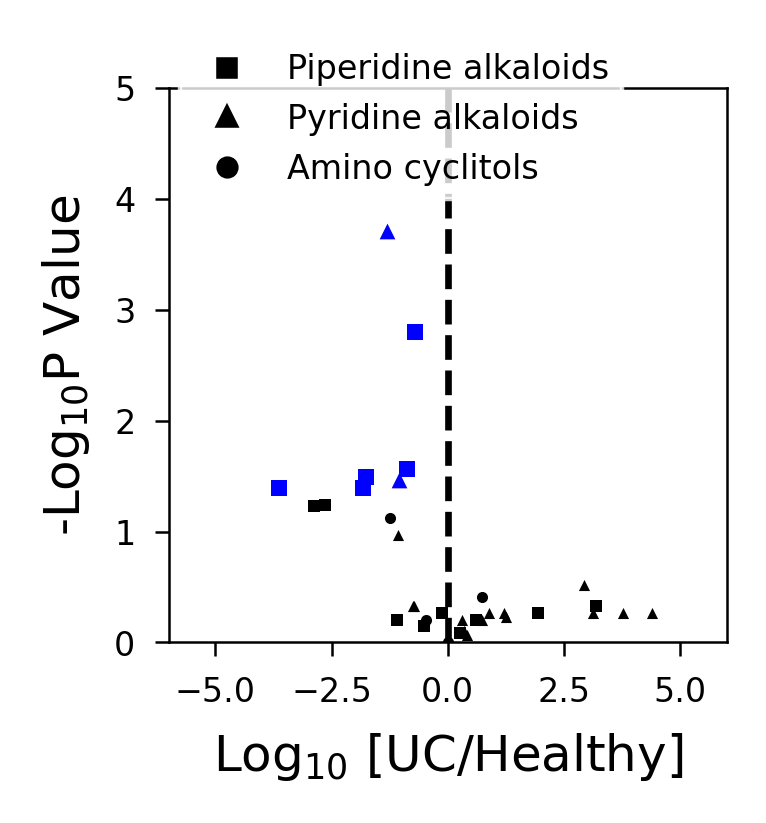

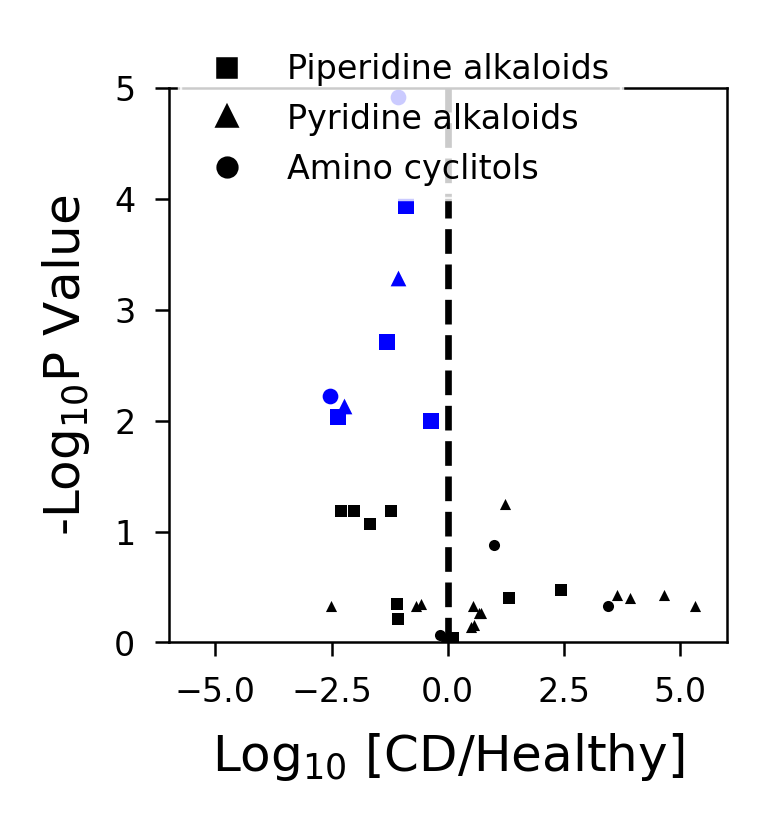

In [171]:
p_thresh = -np.log10(0.05)
fc_thresh = 0.2
p_key = "fdr_bh_log10p"
# p_key = "bonferroni_log10p"
d_to_lim={}
markers = dict(zip(impt_classes, ["s", "^", "o"]))
for compare in ["UC", "CD"]:
        
    compare_df = volcano_df[volcano_df['compare_b'] == compare]
    compare_p, compare_fc = compare_df[p_key], compare_df['log(FC)']
    fig = plt.figure(figsize=(1.8, 1.8), dpi=400)
    ax = plt.gca()
    for cls in impt_classes:
        extra_mask = compare_df['cls'] == cls
        compare_fc_cls, compare_p_cls = compare_fc[extra_mask], compare_p[extra_mask]
        ax.scatter(compare_fc_cls, compare_p_cls, s=4, color = "black", 
                   marker=markers[cls], linewidth=0)

        blue_mask = np.logical_and(compare_fc_cls < -fc_thresh, compare_p_cls > p_thresh)
        print("Downregulated from control:", compare_df["key_id"][extra_mask][blue_mask].values)
        ax.scatter(compare_fc_cls[blue_mask], compare_p_cls[blue_mask], s=8, color = "blue", 
                   marker=markers[cls], linewidth=0)


        red_mask = np.logical_and(compare_fc_cls > fc_thresh, compare_p_cls > p_thresh)
        print("Upregulated from control:", compare_df[extra_mask]["key_id"][red_mask].values)
        ax.scatter(compare_fc_cls[red_mask], compare_p_cls[red_mask], s=8, color = "red", 
                   marker=markers[cls], linewidth=0)
    handles = [Line2D([0], [0], linestyle='none', color="black", markersize=3,
                      label=cls, marker=markers[cls]) for cls in impt_classes]     
    legend = ax.legend(handles=handles, loc=(0.02,0.8), frameon=True, 
                       fancybox=False, fontsize=6,)
    ax.axvline(x=0, linestyle="--", color="black")
    ax.set_xlabel(f"{log_10_str} [{compare}/Healthy]")
    ax.set_ylabel(f"-{log_10_str}P Value")
    ax.set_xlim([-6,6])
    ax.set_ylim([0, 5])
#     ax.set_title(f"{compare} vs. control")
    d_to_lim[compare] = ax.get_xlim(), ax.get_ylim()
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor("white")
    fig.savefig(save_dir / f"volcano_metabolites_{compare}.pdf", bbox_inches="tight", 
                transparent=True)

### Volcano with label legend

Downregulated from control: ['mills_1131' 'mills_931' 'mills_1580' 'mills_961' 'mills_1249']
Upregulated from control: []
Downregulated from control: ['mills_387' 'mills_143']
Upregulated from control: []
Downregulated from control: ['mills_1699']
Upregulated from control: []
Downregulated from control: ['mills_1131' 'mills_931' 'mills_1274' 'mills_961']
Upregulated from control: []
Downregulated from control: ['mills_880' 'mills_143']
Upregulated from control: []
Downregulated from control: ['mills_1396' 'mills_1699']
Upregulated from control: []


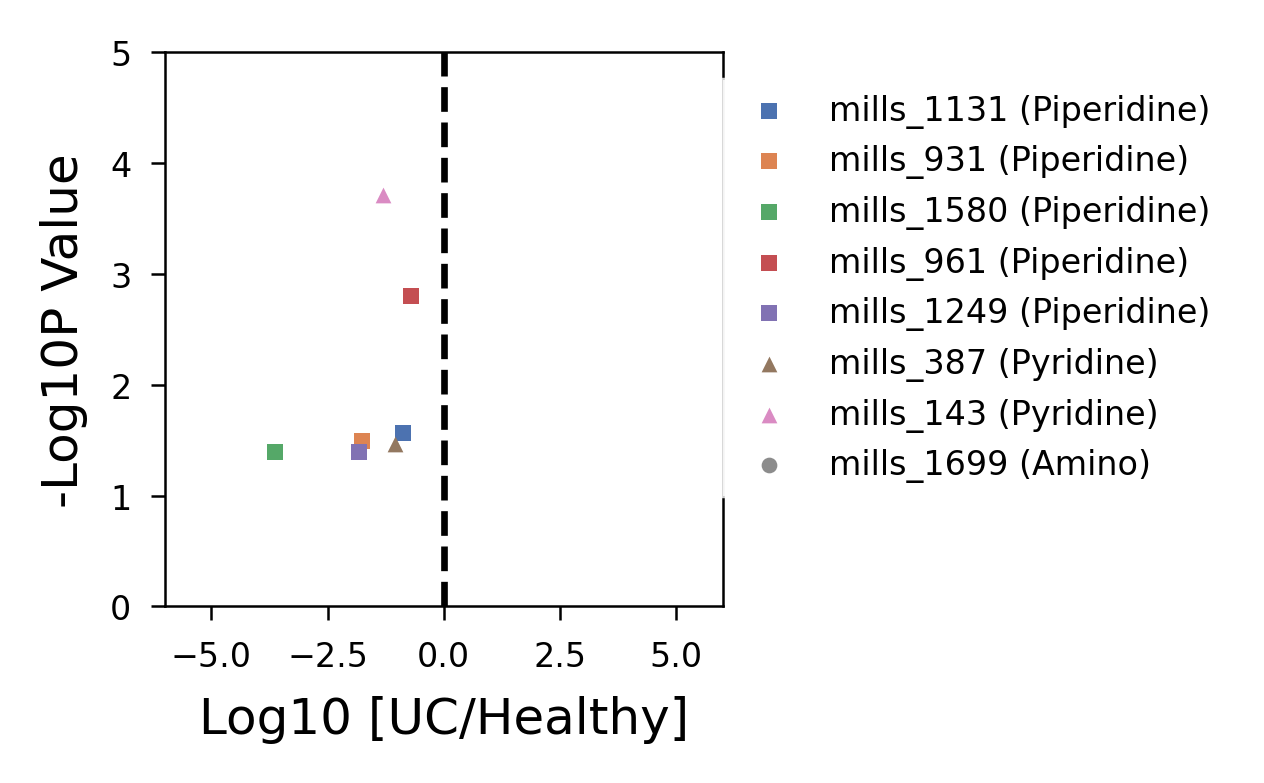

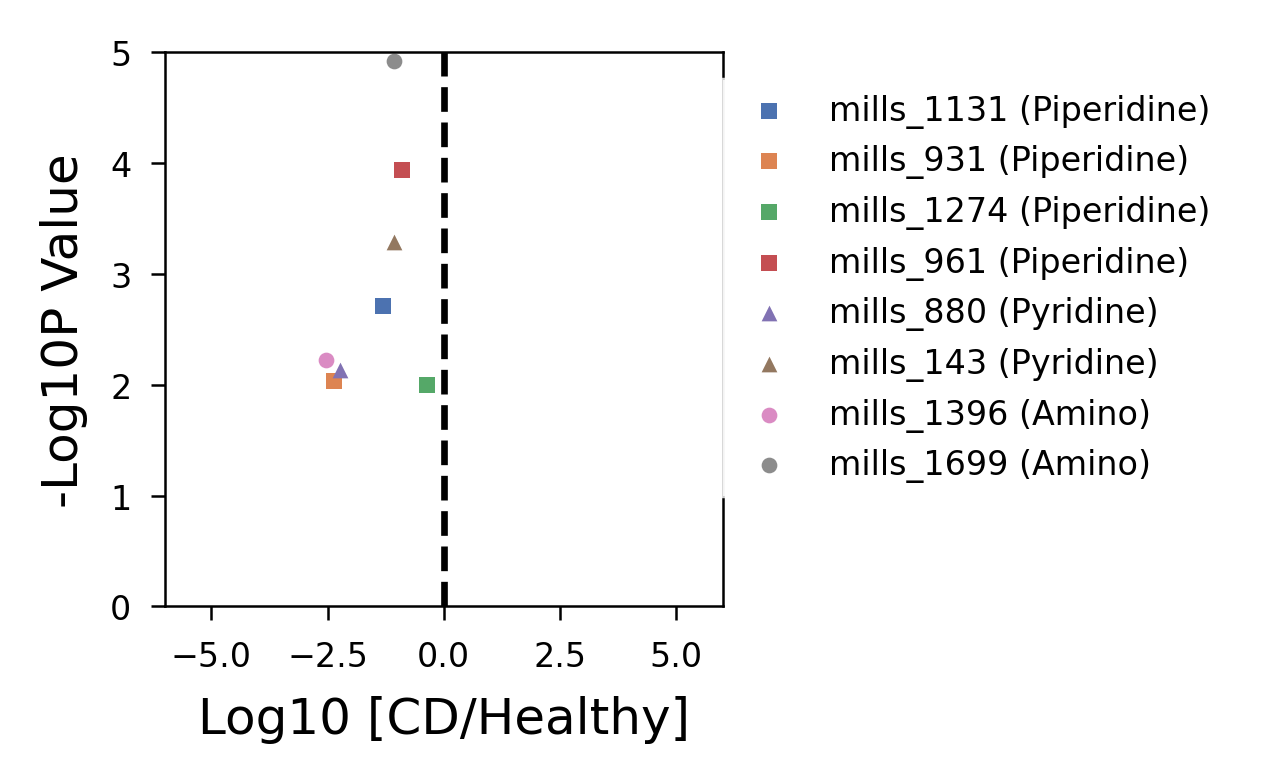

In [172]:
p_thresh = -np.log10(0.05)
fc_thresh = 0.2
p_key = "fdr_bh_log10p"
# p_key = "bonferroni_log10p"
d_to_lim={}
markers = dict(zip(impt_classes, ["s", "^", "o"]))
for compare in ["UC", "CD"]:
        
    compare_df = volcano_df[volcano_df['compare_b'] == compare]
    compare_p, compare_fc = compare_df[p_key], compare_df['log(FC)']
    fig = plt.figure(figsize=(1.8, 1.8), dpi=400)
    ax = plt.gca()
    for cls in impt_classes:
        extra_mask = compare_df['cls'] == cls
        compare_fc_cls, compare_p_cls = compare_fc[extra_mask], compare_p[extra_mask]
#         ax.scatter(compare_fc_cls, compare_p_cls, s=4, color = "black", 
#                    marker=markers[cls], linewidth=0)

        blue_mask = np.logical_and(compare_fc_cls < -fc_thresh, compare_p_cls > p_thresh)
        print("Downregulated from control:", compare_df["key_id"][extra_mask][blue_mask].values)
        for ind, m in enumerate(blue_mask):
            if not m: continue
            name = compare_df["key_id"][extra_mask].values[ind]
            
            ax.scatter(compare_fc_cls.values[ind], compare_p_cls.values[ind], s=8,
                       marker=markers[cls], linewidth=0, label=f"{name} ({cls.split()[0]})", alpha=1)

        red_mask = np.logical_and(compare_fc_cls > fc_thresh, compare_p_cls > p_thresh)
        print("Upregulated from control:", compare_df["key_id"][extra_mask][red_mask].values)
        for ind, m in enumerate(red_mask):
            if not m: continue
            name = compare_df["key_id"][extra_mask].values[ind]

            ax.scatter(compare_fc_cls.values[ind], compare_p_cls.values[ind], s=8,
                       marker=markers[cls], linewidth=0, label=f"{name} ({cls.split()[0]})", alpha=1)
            
    

#     handles = [Line2D([0], [0], linestyle='none', color="black", markersize=3,
#                       label=cls, marker=markers[cls]) for cls in impt_classes]     
    legend = ax.legend(loc=(1.0,0.2), frameon=True,
                       fancybox=False, fontsize=6,)
    ax.axvline(x=0, linestyle="--", color="black")
    ax.set_xlabel(f"Log10 [{compare}/Healthy]")
    ax.set_ylabel("-Log10P Value")
    ax.set_xlim([-6,6])
    ax.set_ylim([0, 5])
#     ax.set_title(f"{compare} vs. control")
    d_to_lim[compare] = ax.get_xlim(), ax.get_ylim()
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor("white")
    fig.savefig(save_dir / f"volcano_metabolites_{compare}_label.pdf", bbox_inches="tight", 
                transparent=True)

#### Map back to HMDB labels

Requires running preprocessing scripts for HMDB first to generate hmdb_ikey_to_id file

In [173]:
hmdb_ikey_to_id = pickle.load(open("../data/raw/hmdb/hmdb_ikey_to_id.p", "rb"))

In [174]:
# Piperdine, # piperdine, # piperidine # Pyridine # piperidine
output_met_nums = [143, 961, 880,  1580]# 1131]#[1131, 931, 961, 143, 1580, 880, 387]
# output_met_nums = [143, 880,  1580, 1131, 1549, 1699]#[1131, 931, 961, 143, 1580, 880, 387]
# output_met_nums = [143, 880,  1580]#[1131, 931, 961, 143, 1580, 880, 387]
output_mets = [id_to_smi[f"mills_{i}"] for i in output_met_nums]
print(output_mets)

['O=C(O)c1ccncc1', 'CC1(C)CC(=O)CC(C)(C)N1', 'CC=CCC(NC(=O)c1[nH]c(C)c(C(C)=O)c1CCC)C(=O)O', 'O=C(C=CC=CC=Cc1ccc2c(c1)OCO2)N1CCCCC1']


In [175]:
temp_key = 'mills_1580'
 # Check class for temp_key 
compare_df = volcano_df[volcano_df['compare_b'] == "UC"]
compare_df[compare_df['key_id'] == temp_key]

,compare_a,compare_b,compare_concat,log(FC),pval,key_id,id_type,cls,bonferroni_log10p,fdr_bh_log10p
9,Healthy_control,UC,Healthy_control_UC,-3.636344,0.00854,mills_1580,compound_id,Piperidine alkaloids,0.488775,1.391865


In [176]:
mols = [Chem.MolFromSmiles(i) for i in output_mets]
ikeys = [Chem.MolToInchiKey(i) for i in mols]
print("\n".join([f"mills_{x}: {i}-- {hmdb_ikey_to_id.get(i)}" for x,i in zip(output_met_nums, ikeys)]))

mills_143: TWBYWOBDOCUKOW-UHFFFAOYSA-N-- HMDB0060665
mills_961: JWUXJYZVKZKLTJ-UHFFFAOYSA-N-- HMDB0031179
mills_880: MZPGGBNBDNYCMJ-UHFFFAOYSA-N-- None
mills_1580: DLKOUKNODPCIHZ-UHFFFAOYSA-N-- HMDB0034371


In [177]:
list(csi_ikeys)[0]

'ZUKRPXSFAZWKHZ-UHFFFAOYSA-N'

In [178]:
[i in csi_ikeys for i in ikeys]

[True, False, False, False]

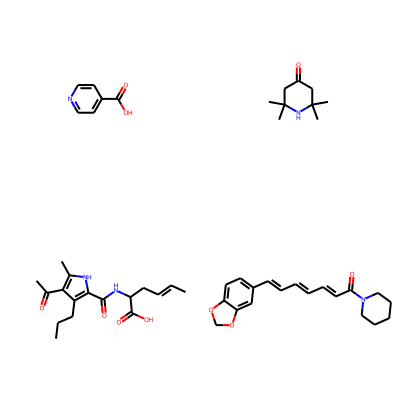

In [179]:
Draw.MolsToGridImage(mols, molsPerRow=2)